# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are: 

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code runs correctly on the original data file.

Some of the parts of this assignment build on the workflow from the first assignment and that part of the course, and so less detailed instructions are provided for this, as you should be able to implement this workflow now without low-level guidance. A substantial portion of the marks for this assignment are associated with making the right choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and certain restrictions on sklearn functions will be made clear in the instruction text. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail, as appropriate to the marks given.

## 1. Investigate Dataset (10% = 3 marks)

In [1]:
# This code imports some libraries that you will need. 
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

### 1.1 Load the dataset [0.5 marks]
Do this from the csv file, `assignment2.csv`, as done in assignment 1 and workshops 2 and 3. Extract the feature names and label names for use later on.  Note that we will be treating the _malignant_ case as our _positive_ case, as this is the standard convention in medicine.

**Print out some information (in text) about the data, to verify that the loading has worked and to get a feeling for what is present in the dataset and the range of the values.**

**Also, graphically show the proportions of the labels in the whole dataset.**

In [2]:
# Your code here
cancer_df=pd.read_csv("assignment2.csv")
cancer_df.head()

label  mean radius  mean texture  mean perimeter   mean area  \
0  malignant    15.494654     15.902542      103.008265  776.437239   
1  malignant    16.229871     18.785613      105.176755  874.712003   
2  malignant    16.345671     20.114076      107.083804  872.563251   
3  malignant    13.001009     19.876997       85.889775  541.281012   
4  malignant    16.416060     17.397533      107.857386  891.516818   

   mean smoothness  mean compactness  mean concavity  mean concave points  \
0         0.104239          0.168660        0.170572             0.085668   
1         0.091843          0.092548        0.081681             0.053670   
2         0.099924          0.123799        0.128788             0.078310   
3         0.113423          0.173069        0.146214             0.069574   
4         0.097321          0.111530        0.125971             0.068575   

   mean symmetry  ...  worst radius  worst texture  worst perimeter  \
0       0.205053  ...     19.522957      22.427276       135.128520   
1       0.180435  ...     19.140235      24.905156       123.886045   
2       0.189756  ...     19.144816      25.601433       125.113036   
3       0.212078  ...     15.565911      26.145119       102.958265   
4       0.179562  ...     18.620376      22.306233       124.002529   

    worst area  worst smoothness  worst compactness  worst concavity  \
0  1286.903131          0.142725           0.407483         0.445992   
1  1234.499997          0.129135           0.223918         0.248846   
2  1202.749973          0.135017           0.314402         0.332505   
3   737.655082          0.161390           0.485912         0.430007   
4  1139.490971          0.133950           0.230996         0.316620   

   worst concave points  worst symmetry  worst fractal dimension  
0              0.171662        0.353211                 0.097731  
1              0.136735        0.284427                 0.085758  
2              0.161497        0.313038                 0.084340  
3              0.167254        0.432297                 0.117705  
4              0.131715        0.269591                 0.080497  

[5 rows x 31 columns]

In [3]:
print(cancer_df.shape)

(300, 31)


In [4]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

In [5]:
print(np.sum(cancer_df.isna()))

label                      0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64


In [6]:
cancer_df.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   300.000000    300.000000      300.000000   300.000000   
mean     14.231808     19.312619       92.727687   664.367372   
std       1.297393      1.572224        8.949937   129.515717   
min      11.560025     15.349270       74.690886   477.371592   
25%      13.356676     18.194791       86.659535   580.383274   
50%      13.976933     19.220652       90.896982   628.004851   
75%      15.103078     20.245660       99.093762   737.444716   
max      19.090091     26.836291      126.168030  1300.788708   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       300.000000        300.000000      300.000000           300.000000   
mean          0.096937          0.106615        0.092591             0.050820   
std           0.005067          0.020819        0.030312             0.014350   
min           0.084651          0.075184        0.050771             0.028701   
25%           0.093305          0.091105        0.069071             0.039507   
50%           0.096722          0.102401        0.084829             0.046744   
75%           0.099995          0.117334        0.107994             0.060606   
max           0.114500          0.192880        0.212704             0.105212   

       mean symmetry  mean fractal dimension  ...  worst radius  \
count     300.000000              300.000000  ...    300.000000   
mean        0.182546                0.062841  ...     16.460566   
std         0.010754                0.002736  ...      1.798202   
min         0.157059                0.057830  ...     13.279265   
25%         0.175353                0.060950  ...     15.148044   
50%         0.181685                0.062477  ...     16.007171   
75%         0.187789                0.064149  ...     17.656889   
max         0.226448                0.076091  ...     22.676185   

       worst texture  worst perimeter   worst area  worst smoothness  \
count     300.000000       300.000000   300.000000        300.000000   
mean       25.772128       108.563914   900.644633          0.133424   
std         2.346310        12.500033   209.738842          0.008678   
min        20.144214        87.110184   633.771881          0.110342   
25%        24.058893        99.229249   752.124790          0.127682   
50%        25.689861       105.540619   828.667704          0.133064   
75%        27.333610       116.274995  1011.628413          0.138650   
max        34.614459       150.353232  1796.820974          0.164583   

       worst compactness  worst concavity  worst concave points  \
count         300.000000       300.000000            300.000000   
mean            0.261732         0.282075              0.118146   
std             0.063535         0.079831              0.024552   
min             0.167098         0.152272              0.066927   
25%             0.215767         0.219671              0.098389   
50%             0.247022         0.267894              0.115679   
75%             0.298732         0.325278              0.136687   
max             0.543118         0.635074              0.179794   

       worst symmetry  worst fractal dimension  
count      300.000000               300.000000  
mean         0.293620                 0.084556  
std          0.025620                 0.007427  
min          0.240341                 0.072745  
25%          0.277676                 0.079636  
50%          0.288994                 0.082610  
75%          0.305227                 0.087645  
max          0.432297                 0.128288  

[8 rows x 30 columns]

In [7]:
target=cancer_df['label']
features=cancer_df.drop('label',axis=1)
print(f'Feature names are : {features.columns}')

Feature names are : Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


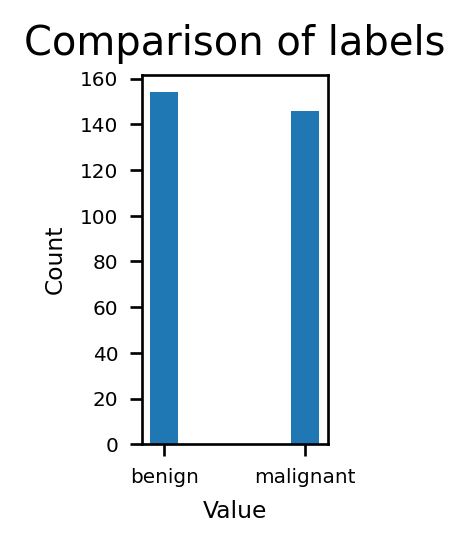

In [8]:
#count based on the labels
value_count= target.value_counts()

plt.figure(figsize=(1,2))

plt.bar(value_count.index,value_count.values,width=0.2)

plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Comparison of labels")
plt.show()

### 1.2 Visualise the dataset [1.5 marks]

As this data is well curated by the client already, you do not need to worry about outliers, missing values or imputation in this case, but be aware that this is the exception, not the rule.

To familiarise yourself with the nature and information contained in the data, display histograms for the data according to the following instructions:
 - **display histograms** for each feature in the _mean_ group, but on _each_ histogram **have the two classes displayed together in one plot** (see example plot below and a code fragment to help you) - and note that your plot does not need to look exactly the example here;
 - **repeat this** for the _standard error_ and _worst_ groups;
 - make sure that in all cases you clearly label the plots and the classes in histograms.

<center><img src="Example_Hist_Plot.png" width="300" alt="Example plot of histogram"></center>

In [9]:
def hist_plot(features, df_name):
    # number of features (excluding label column)
    Nrows=len(features.columns)-1

    # two features for per column
    Ncols=2

    fig, axes = plt.subplots((Nrows+1)//Ncols, Ncols, figsize=(8,12))
    plt.title(df_name.capitalize()+" group")
    
    for i,column in enumerate(features.columns[:-1]):
        row=i//Ncols
        col=i%Ncols
        sns.histplot(data=features, x=column, hue="label", bins=30, kde=True, alpha=0.7,ax=axes[row,col], edgecolor=None)
        axes[row,col].set_title(f'{column} Histogram')
        axes[row,col].set_xlabel(f'{column} values')
        axes[row,col].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()



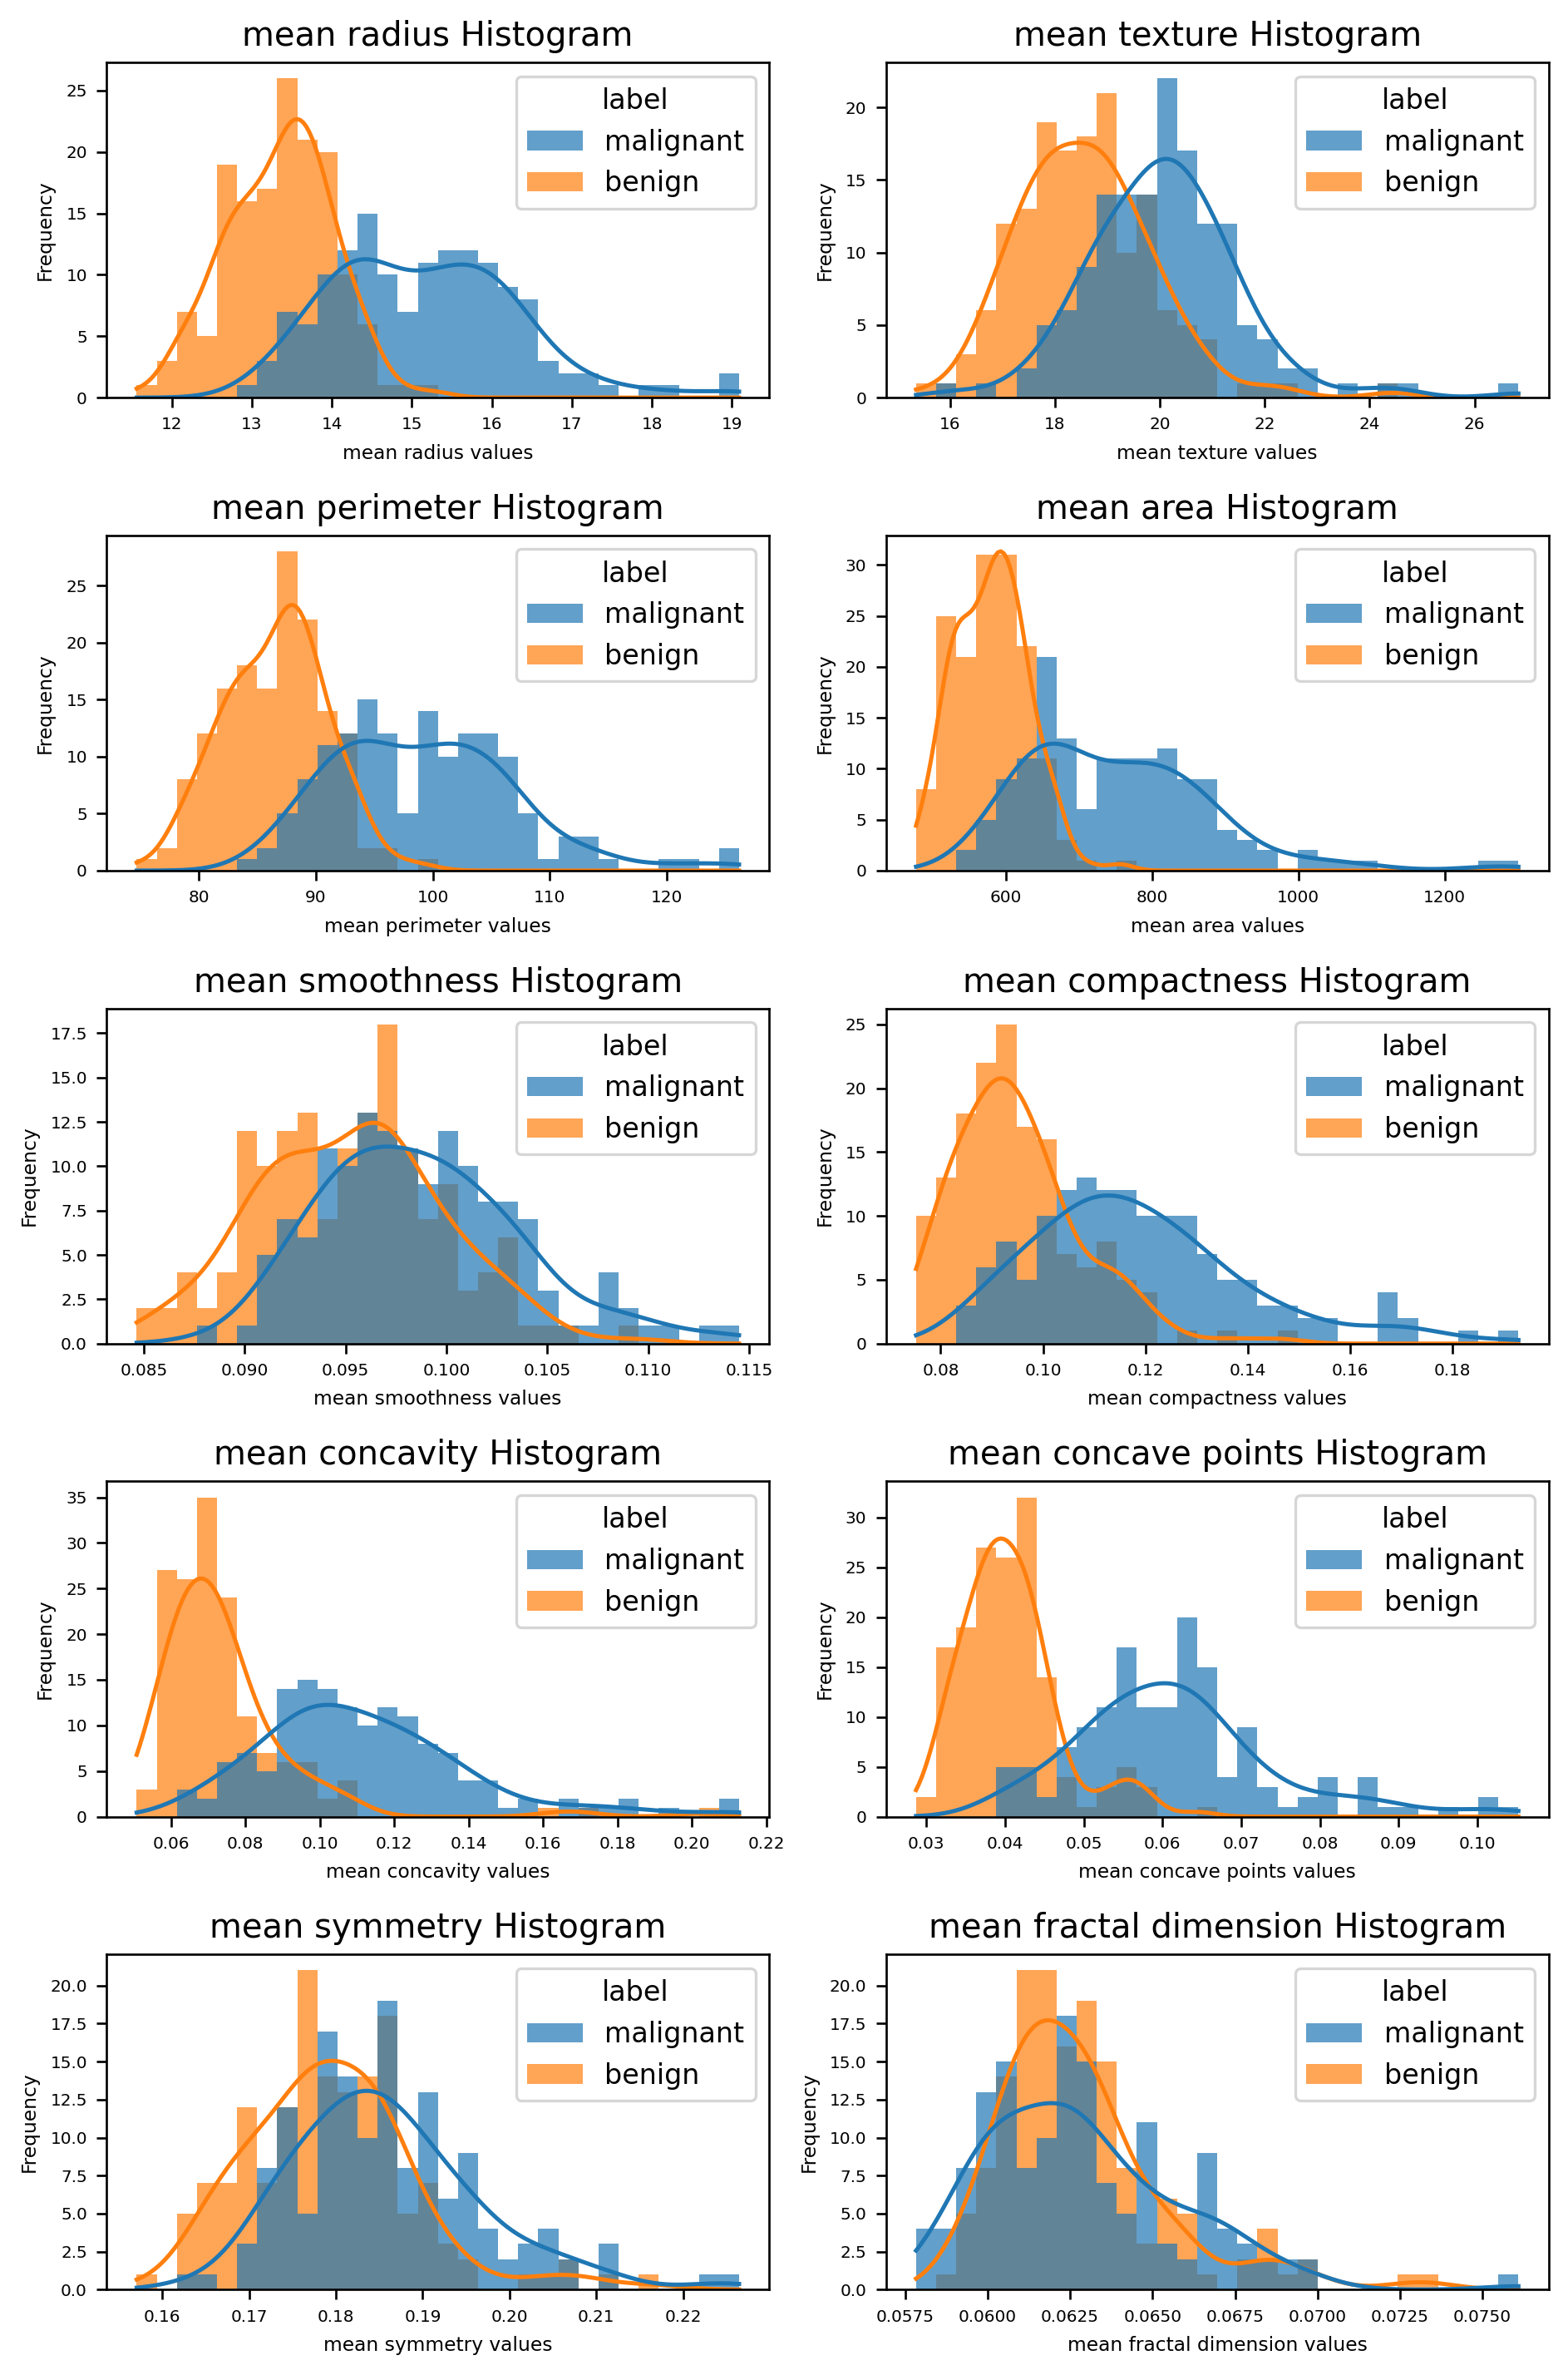

In [10]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
#extracting mean features
mean_features=[feature for feature in cancer_df.columns if 'mean' in feature]
mean_features.append('label')
mean_features=cancer_df[mean_features]

hist_plot(mean_features,"mean")

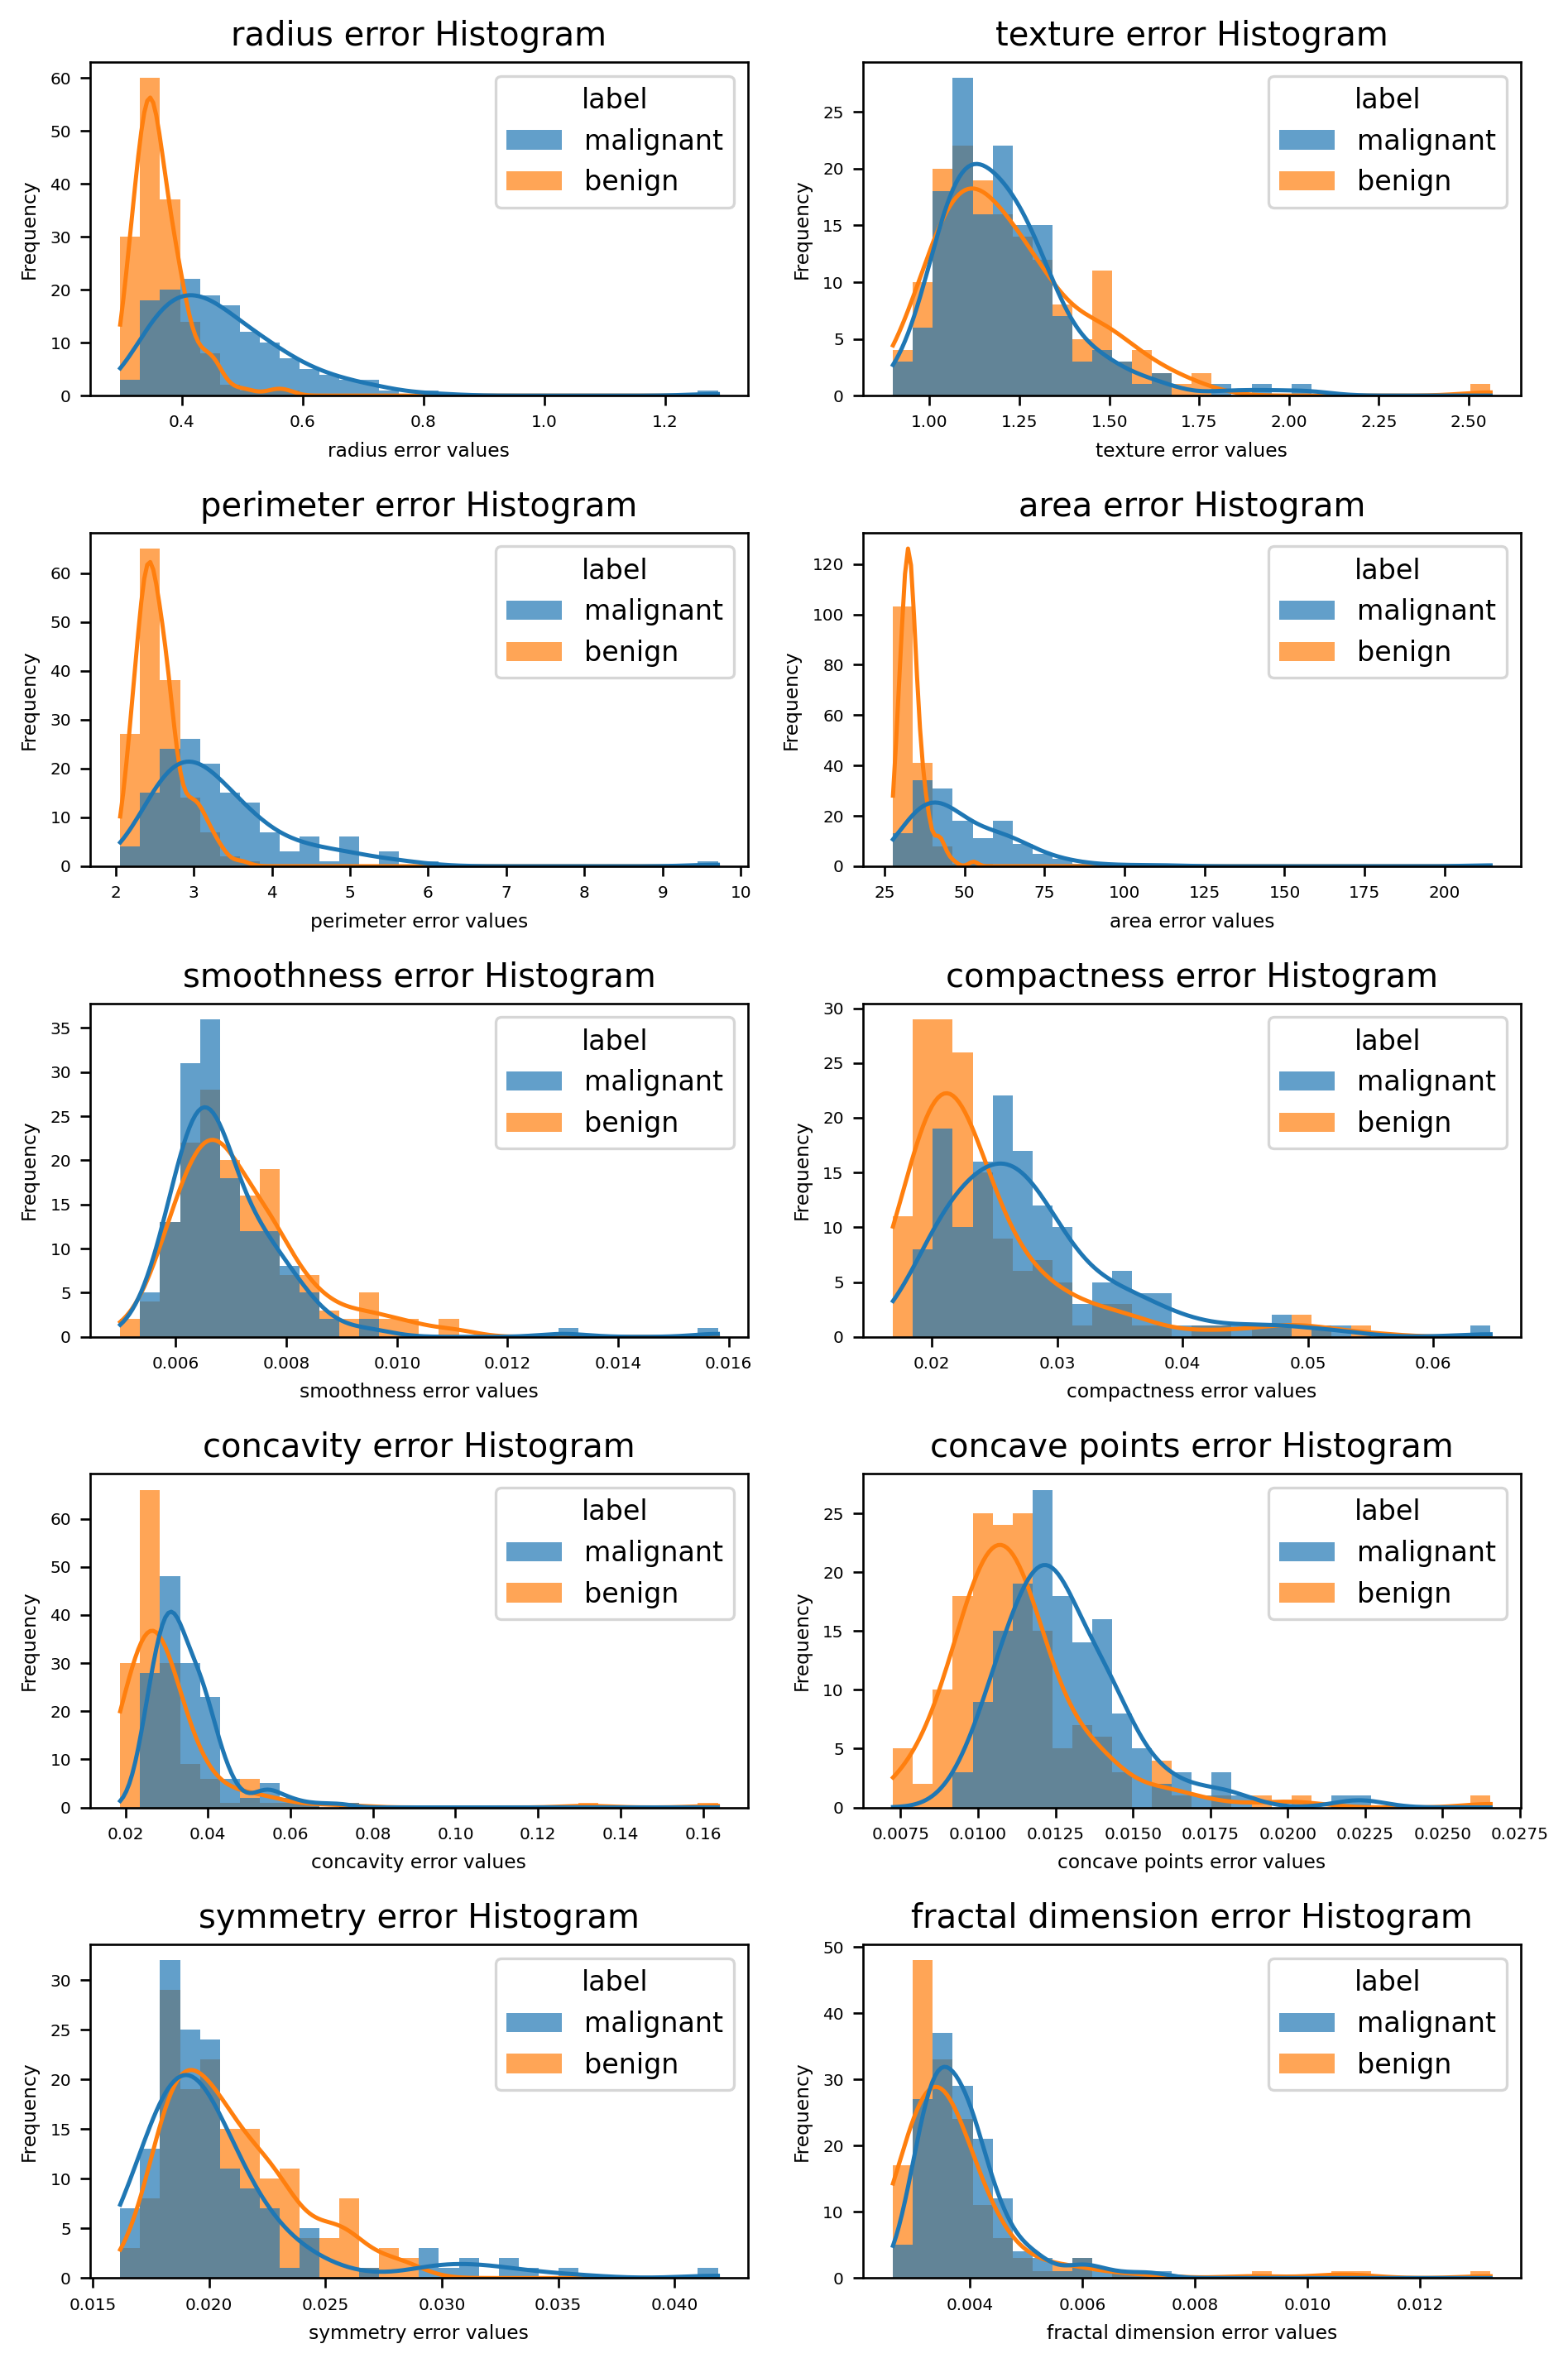

In [11]:
#extracting error features
error_features=[feature for feature in cancer_df.columns if 'error' in feature]
error_features.append('label')
error_features=cancer_df[error_features]

hist_plot(error_features, "error")

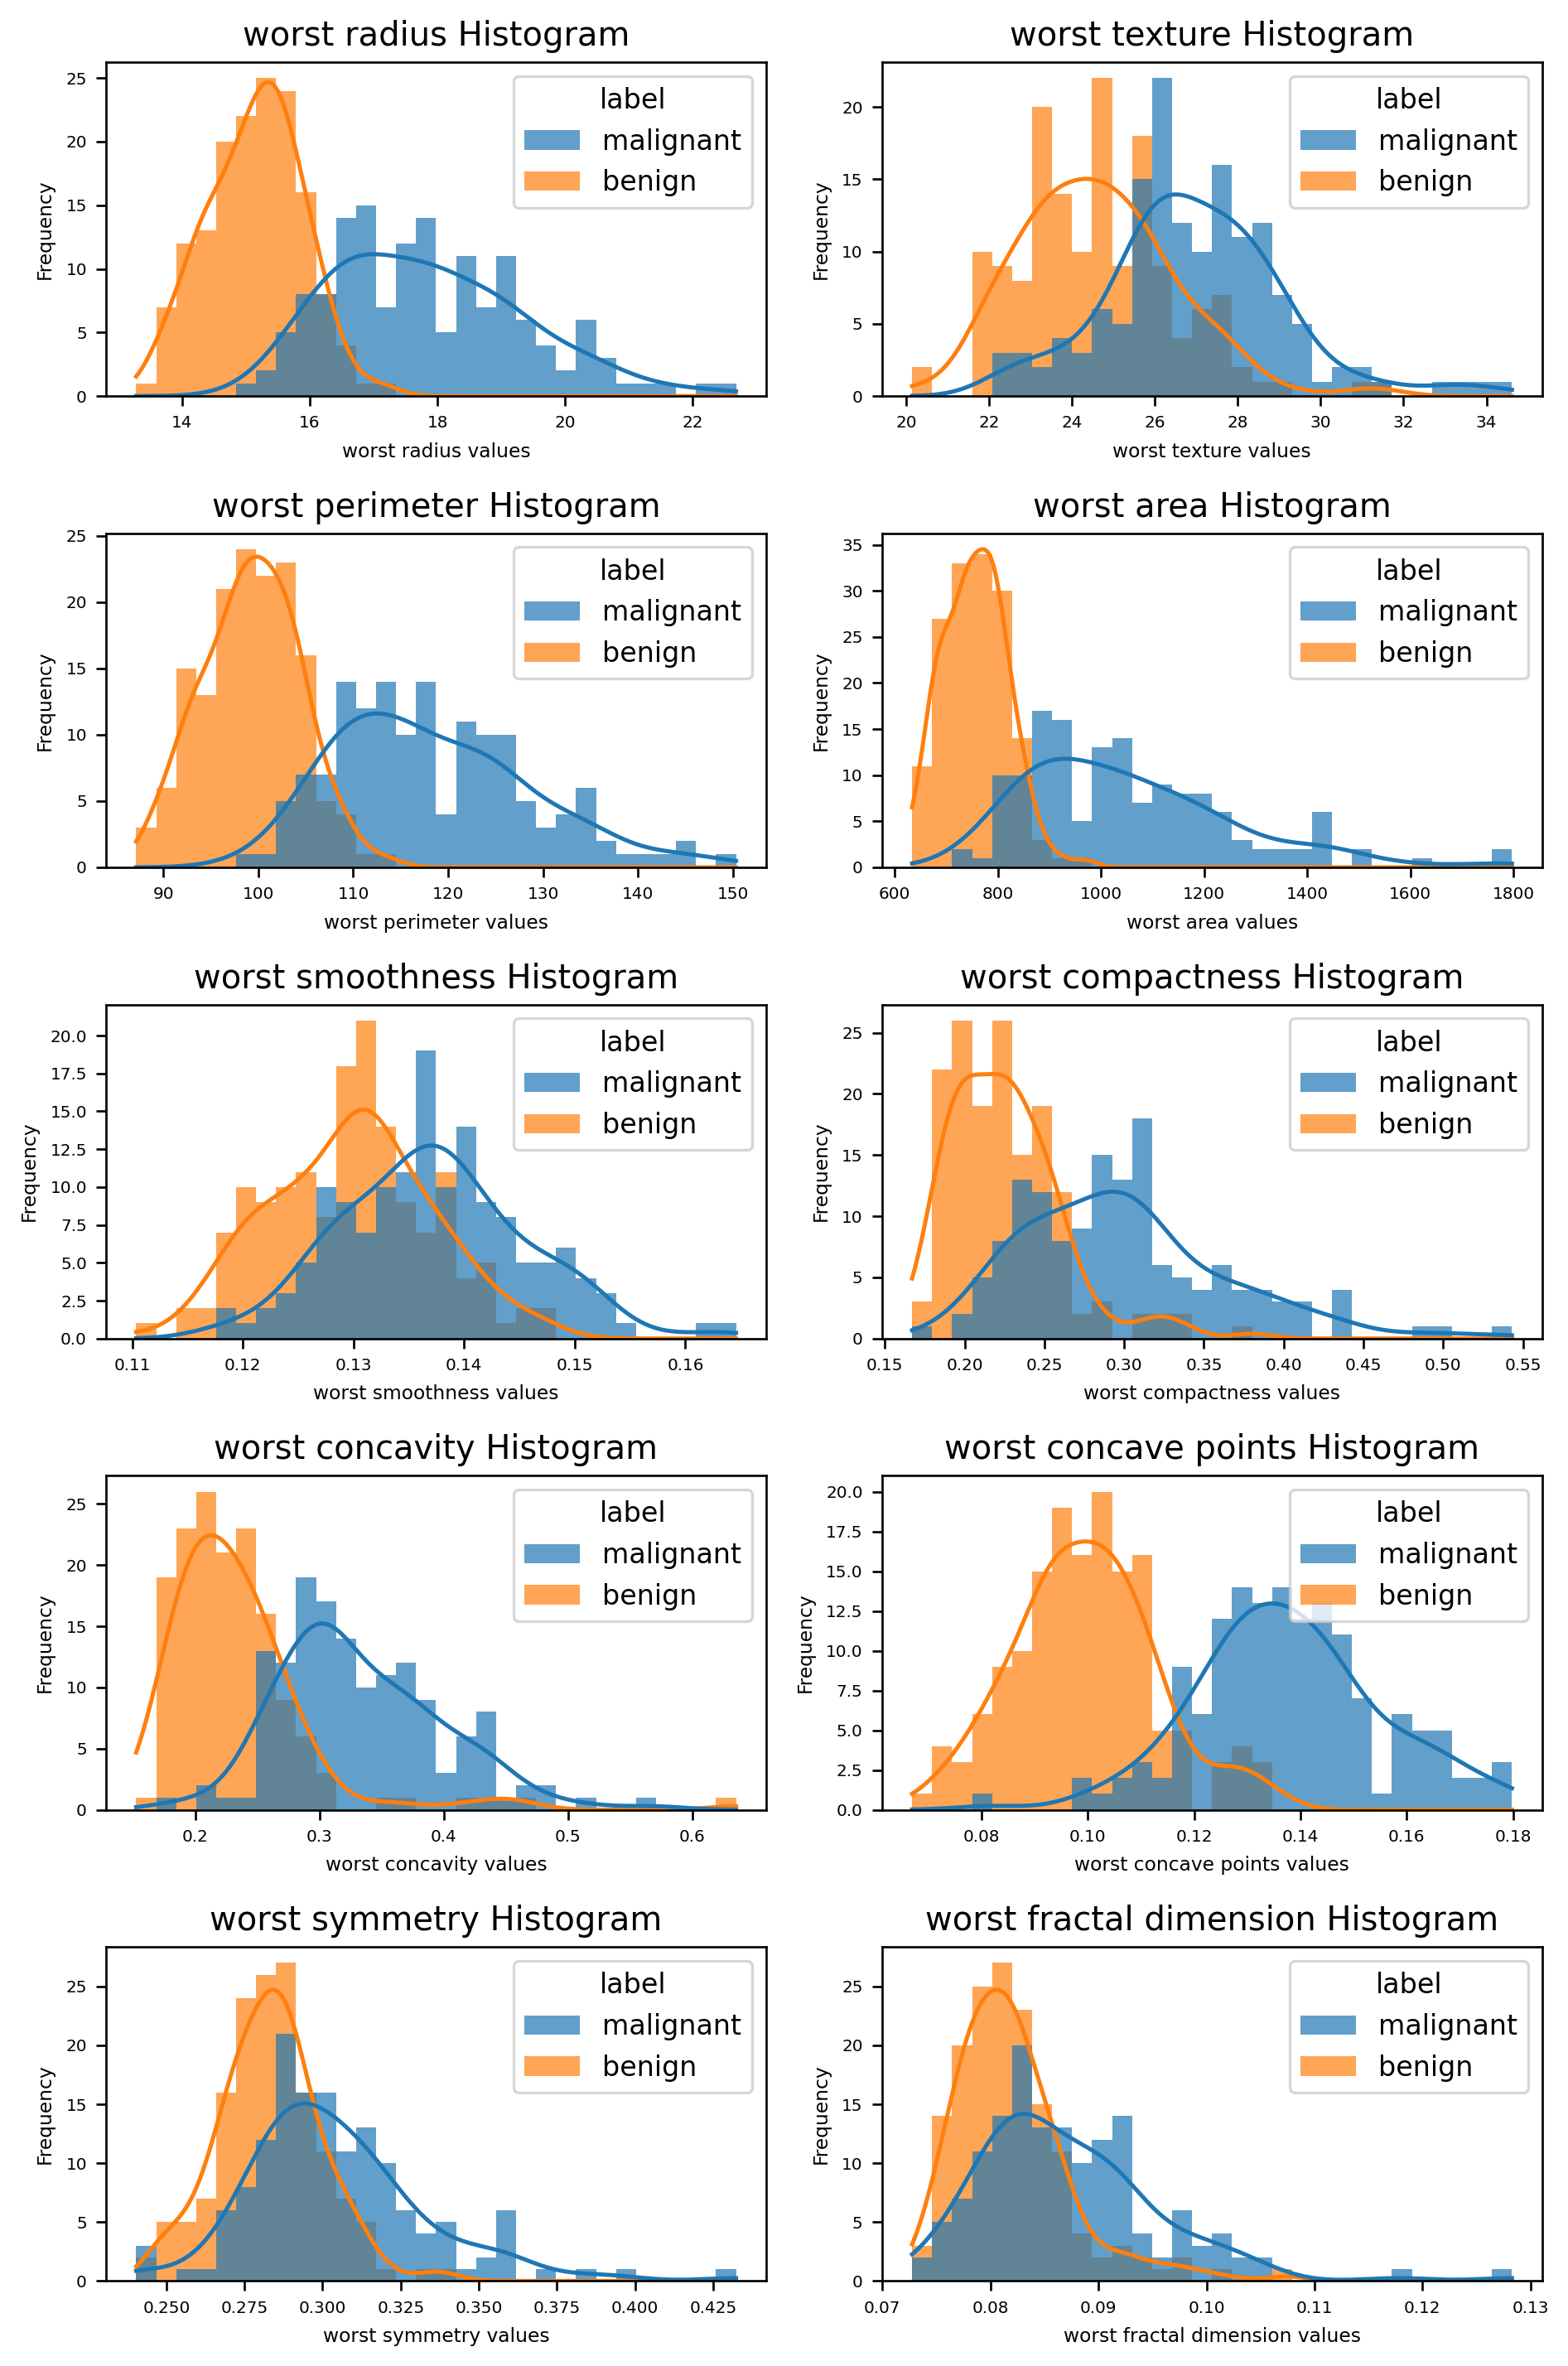

In [12]:
#extracting worst features
worst_features=[feature for feature in cancer_df.columns if 'worst' in feature]
worst_features.append('label')
worst_features=cancer_df[worst_features]

hist_plot(worst_features, "worst")

### Taking positive cases (malignant) as 1 and negative cases (benign) as 0

Text(0.5, 1.0, 'Heatmap')

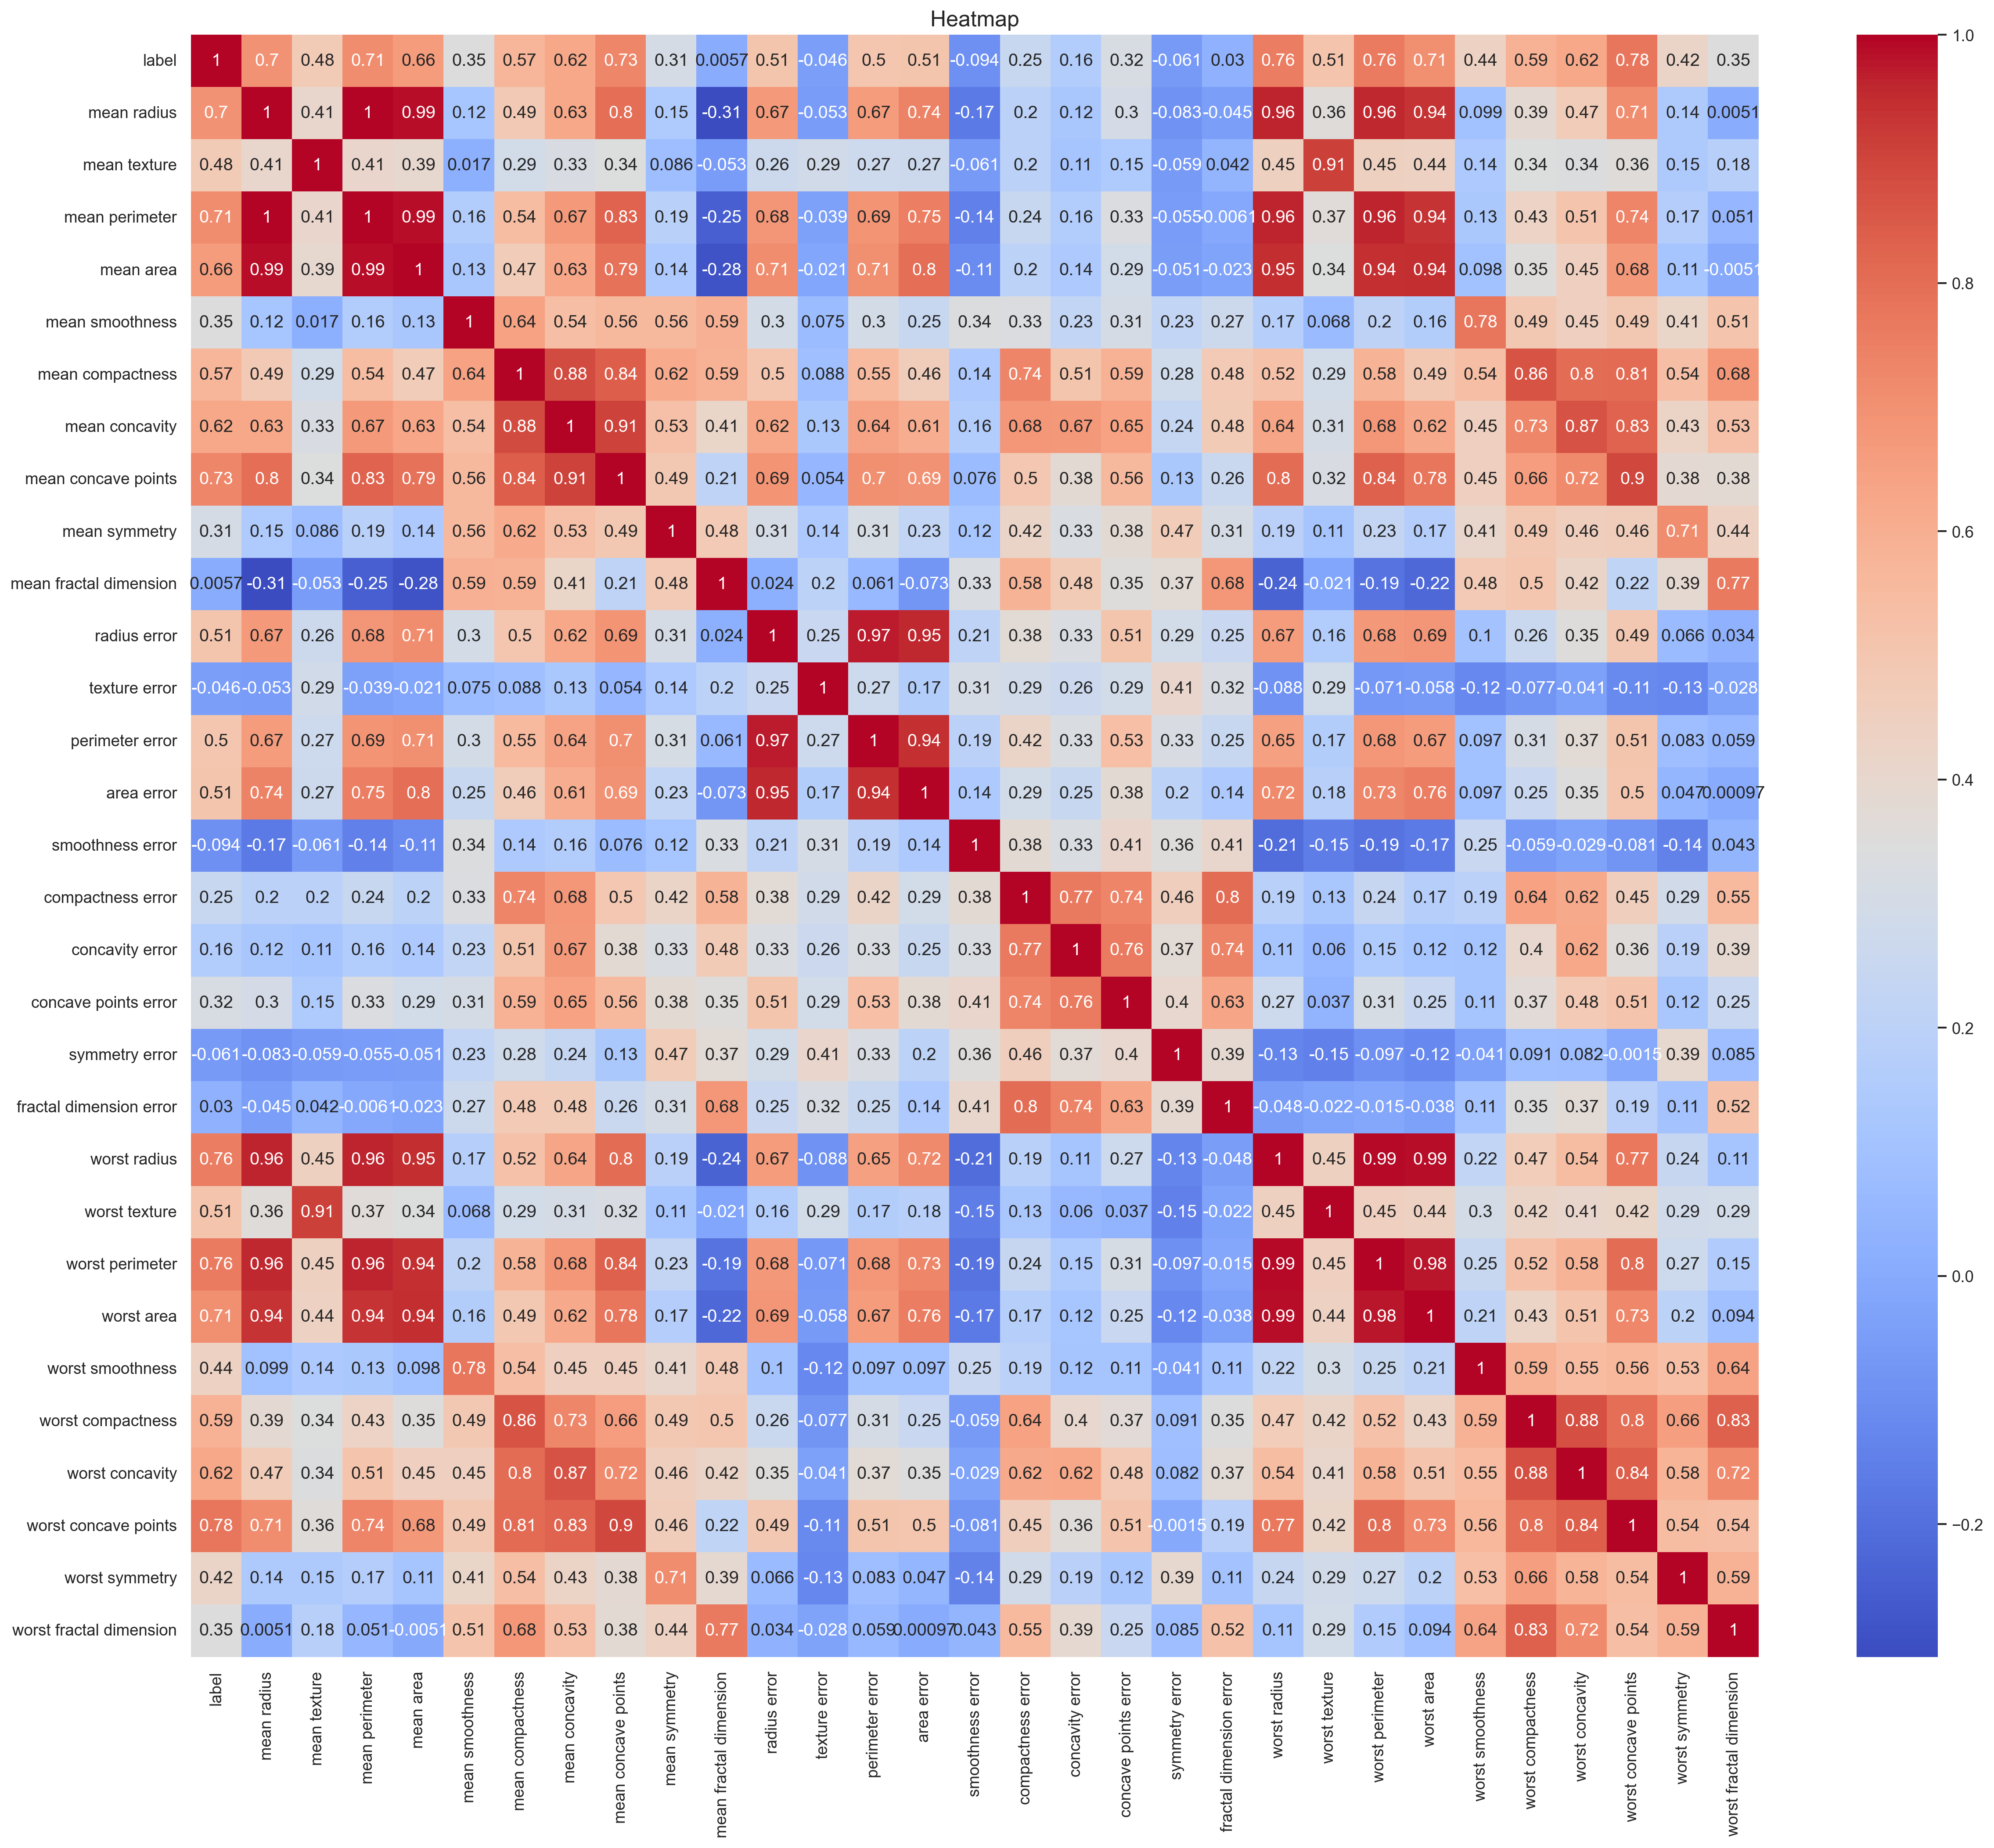

In [13]:
cancer_df['label']=cancer_df['label'].replace({'malignant':1, 'benign':0})

# feature correlation heatmap
sns.set(rc={'figure.figsize':(24,20)})
heatmap=sns.heatmap(cancer_df.corr(),cmap='coolwarm', annot=True, linecolor='white')
heatmap.set_title("Heatmap",fontdict={'fontsize':15})

### 1.3 Ranking the features [0.5 marks]

**Based on the histograms, which do you think are the 3 strongest features for discriminating between the classes?**

# Answer
The 3 strongest features for discriminating between the classes would be ***worst concave points, worst perimeter*** and ***worst radius***, but in overall the features radius, perimeter and area features are also discriminating as much when considering their mean, error and worst data values they appear to have a higher correlation (positve or negative) with the target variable in comparison with the rest of the features.

### 1.4 Splitting the dataset [0.5 marks]

Split the dataset into appropriate subsets. You must choose what the subsets are and how big they are. However, we want to make sure the proportion of the two classes is consistent across all datasets, so use the _stratify_ option, as used in workshops 5 and 6. Verify the size and label distribution in each dataset.

In [15]:
# Your code here
from sklearn.model_selection import train_test_split

# Taking positive cases (malignant) as 1 and negative cases (benign) as 0
target=np.where(target=='malignant',1,0)

print("Before split")
positive_df=np.count_nonzero(target)
print(f'Label distribution percentage')
print(f'Training: Positive= {round(positive_df/len(target)*100,2)}%, Negative= {round((len(target)-positive_df)/len(target)*100,2)}%')
print('-----------------------------------')

# Training and test dataset split
X_train_set,X_test,y_train_set,y_test = train_test_split(features,target,test_size=0.2,random_state=42, stratify=target)
X_train,X_val,y_train,y_val = train_test_split(X_train_set,y_train_set,test_size=0.18, random_state=42, stratify=y_train_set)

positive_train=np.count_nonzero(y_train)
positive_test=np.count_nonzero(y_test)
positive_val= np.count_nonzero(y_val)
print('After the split')
print(f'Train data size : {len(y_train)}')
print(f'Test data size : {len(y_test)}')
print(f'Validation data size : {len(y_val)}')
print('--------------------------------------')
print(f'Label distribution percentages')
print(f'Training: Positive= {round(positive_train/len(y_train)*100,2)}%, Negative= {round((len(y_train)-positive_train)/len(y_train)*100,2)}%')
print(f'Testing: Positive= {round(positive_test/len(y_test)*100,2)}%, Negative= {round((len(y_test)-positive_test)/len(y_test)*100,2)}%')
print(f'Validation: Positive= {round(positive_val/len(y_val)*100,2)}%, Negative= {round((len(y_val)-positive_val)/len(y_val)*100,2)}%')


Before split
Label distribution percentage
Training: Positive= 48.67%, Negative= 51.33%
-----------------------------------
After the split
Train data size : 196
Test data size : 60
Validation data size : 44
--------------------------------------
Label distribution percentages
Training: Positive= 48.98%, Negative= 51.02%
Testing: Positive= 48.33%, Negative= 51.67%
Validation: Positive= 47.73%, Negative= 52.27%


## 2. Build, Train and Optimise Classifiers (60% = 18 marks)

### 2.1 Pipeline [0.5 marks]
**Build a pre-processing pipeline** that includes imputation (as even though we don't strictly need it here it is a good habit to always include it) and other appropriate pre-processing.  

In [16]:
# Your code here
from sklearn.impute import SimpleImputer

pre_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

### 2.2 Baseline measurements [1.5 marks]

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measure and display the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

Code is given below for the latter metrics (all metrics are discussed in lecture 4 and many are in workshop 4).

Also **calculate and display the confusion matrix** for each baseline case, using a heatmap and numbers (as in workshop 4). 

In [17]:
from sklearn.metrics import fbeta_score, make_scorer, balanced_accuracy_score,recall_score, precision_score, roc_curve, auc, f1_score
import random

def scorer(y_true,y_pred):

    f10_scorer = make_scorer(fbeta_score, beta=10)
    f01_scorer = make_scorer(fbeta_score, beta=0.1)

    def f10_score(yt,yp):
        return fbeta_score(yt, yp, beta=10)

    def f01_score(yt,yp):
        return fbeta_score(yt, yp, beta=0.1)

    ba_case = balanced_accuracy_score(y_true, y_pred)
    recall_case = recall_score(y_true=y_true, y_pred=y_pred, zero_division=0)
    precision_case = precision_score(y_true=y_true, y_pred=y_pred,zero_division=0)
    fpr_cls, tpr_cls, thresholds_cls = roc_curve(y_true,y_pred, pos_label=1)
    auc_cls = auc(fpr_cls,tpr_cls)
    f1_cls = f1_score(y_true, y_pred,zero_division=0)
    fbeta01_cls = f01_score(y_true, y_pred)
    fbeta10_cls = f10_score(y_true, y_pred)
    
    print(f"Balanced Accuracy : {round(ba_case,3)}")
    print(f'Recall : {round(recall_case,3)}')
    print(f'Precision : {round(precision_case,3)}')
    print(f'AUC : {round(auc_cls,3)}')
    print(f'f1score : {round(f1_cls,3)}')
    print(f'fbeta with beta=0.1 : {round(fbeta01_cls,3)}')
    print(f'fbeta with beta=10 : {round(fbeta10_cls,3)}')


In [18]:
print("Baseline measurements")

# baseline case 1 (class 1)
baseline_cls1=np.full_like(y_val,0)
print('--------------------------------------')
print("Baseline 1 Class 1")
scorer(y_val,baseline_cls1)

# baseline case 2 (class 2)
baseline_cls2=np.full_like(y_val,1)
print('--------------------------------------')
print("Baseline 2 Class 2")
scorer(y_val,baseline_cls2)

# baseline case 3
random.seed(42)
baseline_cls3 = np.array([random.choice([0,1]) for i in range(len(y_val))])
print('--------------------------------------')
print("Baseline 3")
scorer(y_val,baseline_cls3)

Baseline measurements
--------------------------------------
Baseline 1 Class 1
Balanced Accuracy : 0.5
Recall : 0.0
Precision : 0.0
AUC : 0.5
f1score : 0.0
fbeta with beta=0.1 : 0.0
fbeta with beta=10 : 0.0
--------------------------------------
Baseline 2 Class 2
Balanced Accuracy : 0.5
Recall : 1.0
Precision : 0.477
AUC : 0.5
f1score : 0.646
fbeta with beta=0.1 : 0.48
fbeta with beta=10 : 0.989
--------------------------------------
Baseline 3
Balanced Accuracy : 0.495
Recall : 0.381
Precision : 0.471
AUC : 0.495
f1score : 0.421
fbeta with beta=0.1 : 0.469
fbeta with beta=10 : 0.382


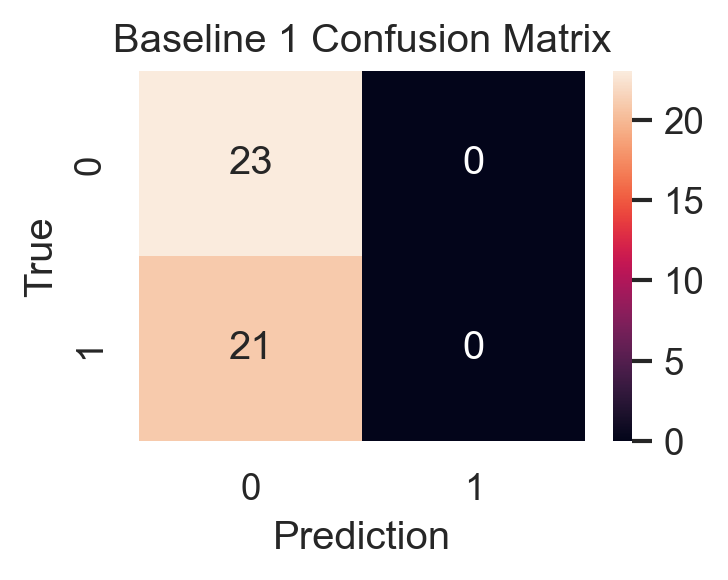

In [19]:
# Confusion matrix for baseline 1 class 1
cmat = confusion_matrix(y_true=y_val, y_pred=baseline_cls1)
plt.subplots(figsize=(3,2))
sns.heatmap(cmat,annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Baseline 1 Confusion Matrix')
plt.show()

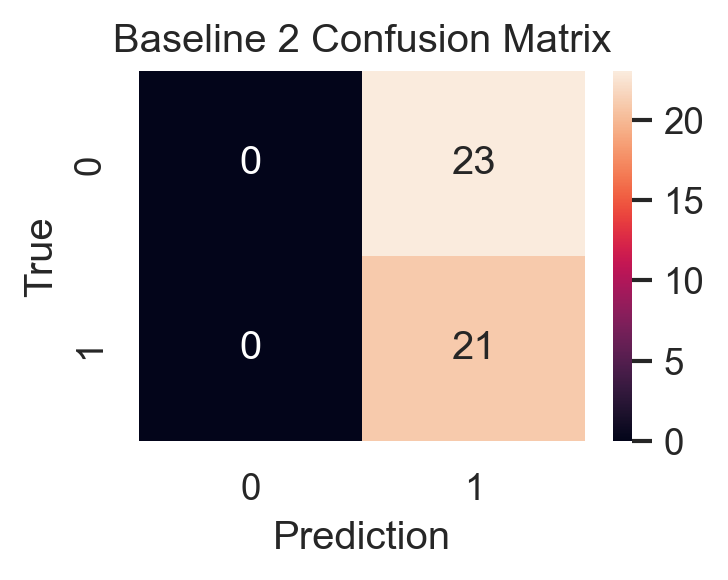

In [20]:
# Confusion matrix for baseline 2 class 2
cmat = confusion_matrix(y_true=y_val, y_pred=baseline_cls2)
plt.subplots(figsize=(3,2))
sns.heatmap(cmat,annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Baseline 2 Confusion Matrix')
plt.show()

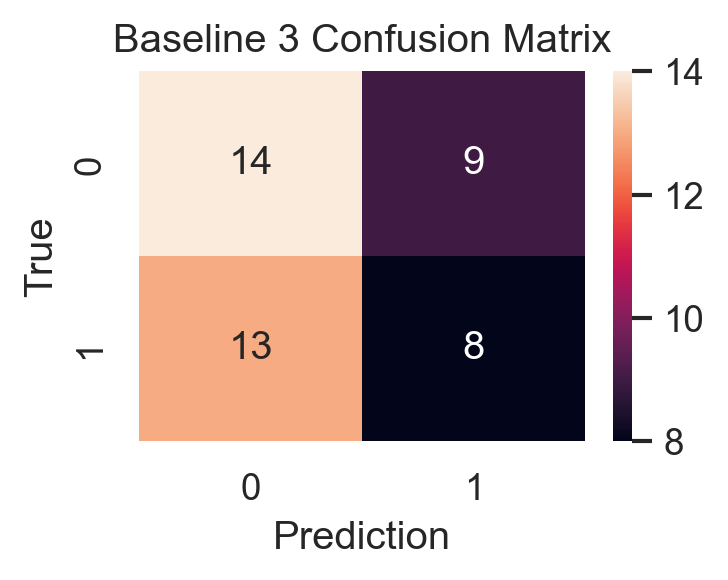

In [21]:
# Confusion matrix for baseline 3
cmat = confusion_matrix(y_true=y_val, y_pred=baseline_cls3)
plt.subplots(figsize=(3,2))
sns.heatmap(cmat,annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Baseline 3 Confusion Matrix')
plt.show()

### 2.3 Choose a performance metric [0.5 marks]

Based on the above baseline tests and the client's requirements, **choose a performance metric** to use for evaluating/driving your machine learning methods.  **Give a reason for your choice.**

# Answer
Taking into consideration that the dataset is almost balanced (almost equal number of samples for both benign and malignant), and the fact that for a cancer classification there maybe false positives and false negatives.

As precision focuses on minimising false positives, which is useful when misclassifying positive cases that can have significant consequences. While recall focuses on minimising false negatives, which are crucial when detecting all positive cases are a priority, but if we were to compare 2 models that both had the metric of precision and recall it would make it difficult to decide which model performed better if and when one model did well in precision while the other in recall. Therefore, the choice of metric would be ***F1-score*** which gives equal weightage to both of those metrics.

### 2.4 SGD baseline [1 mark]

For a stronger baseline, **train and evaluate** the Stochastic Gradient Descent classifier (as seen in workshop 5). For this baseline case use the default settings for all the hyperparameters.

In [43]:
# Your code here
from sklearn.linear_model import SGDClassifier

sgd_pipe=Pipeline([('preprocess',pre_pipeline),('sgd', SGDClassifier())])
sgd_pipe.fit(X_train,y_train)
sgd_val_predict=sgd_pipe.predict(X_val)
scorer(y_val,sgd_val_predict)

Balanced Accuracy : 0.933
Recall : 0.952
Precision : 0.909
AUC : 0.933
f1score : 0.93
fbeta with beta=0.1 : 0.91
fbeta with beta=10 : 0.952


### 2.5 Confusion matrix [1 mark]

Calculate and display the normalized version of the confusion matrix.  From this **calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.  Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?**

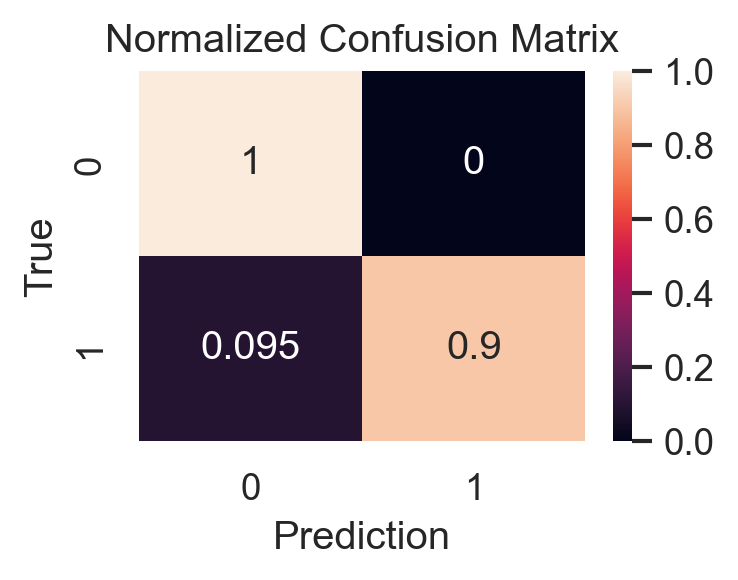

In [25]:
# Your code here
cmat = confusion_matrix(y_true=y_val, y_pred=sgd_val_predict, normalize='true')
plt.subplots(figsize=(3,2))
sns.heatmap(cmat,annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

In [26]:
true_neg,false_pos,false_neg,true_pos=cmat.ravel()
false_negative=false_neg/(false_neg+true_pos)
false_negative

0.09523809523809523

# Answer
The probability that a sample from a person with a malignant tumour is given a result that they do not have cancer - approx. 9.52%

This relates to the client's condition of having 95% accuracy of detecting cancer, in this model it is almost having a false negative rate of 9.5%. Which suggests that this baseline does not satisfy the clients requirements

# calculate the probability

### 2.6 Main classifier [11 marks]

**Train and optimise the hyperparameters** to give the best performance for **each of the following classifiers**:
 - KNN (K-Nearest Neighbour) classifier
 - Decision tree classifier
 - Support vector machine classifier
 - SGD classifier
 
Follow best practice as much as possible here. You must make all the choices and decisions yourself, and strike a balance between computation time and performance.

You can use any of the sci-kit learn functions in sklearn.model_selection.cross* and anything used in workshops 3, 4, 5 and 6. Other hyper-parameter optimisation functions apart from these cannot be used (even if they are good and can be part of best practice in other situations - for this assignment everyone should assume they only have very limited computation resources and limit themselves to these functions).

**Display the performance of the different classifiers and the optimised hyperparameters.**

**Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.**

In [27]:
from sklearn.model_selection import cross_validate

def crossValidation (x_train, y_train, pipeline,show=False):
    cv_results = cross_validate(pipeline, x_train, y_train, cv=5, scoring='f1')
    df=pd.DataFrame.from_dict(cv_results)
    df.index+=1
    if show:
        display(df)
    print(f"\nMean of cross validation test score {np.mean(cv_results['test_score'])}")
    print(f"\nStandard deviation of test_score {cv_results['test_score'].std()}")
    print("")


def gridSearch(X_train, y_train, pipeline, parameters,show=False):
    # scoring={'f1':'f1', 'auc':'roc_auc'}
    gridCV= GridSearchCV(pipeline, parameters,cv=5, scoring='f1')
    gridCV.fit(X_train, y_train)   
    grid_df=pd.DataFrame.from_dict(gridCV.cv_results_)
    params_df=pd.DataFrame(grid_df['params'].values.tolist())
    grid_df.update(params_df)
    grid_df.drop(['params'],axis=1,inplace=True)
    grid_df.sort_values(by=['rank_test_score'],inplace=True)
    if show:
        display(grid_df.head(10))
    print("Best Parameters :")
    for key, value in gridCV.best_params_.items():
        print(f'{key} : {value}')
    print(f'F1 Score : {gridCV.score(X_train,y_train)}, Best mean test score: {gridCV.best_score_}')
    return gridCV


In [28]:
# Your code here
from sklearn.neighbors import KNeighborsClassifier

knn_pipe=Pipeline([('preprocess',pre_pipeline),('knn', KNeighborsClassifier())])

crossValidation(X_train,y_train, knn_pipe)

knn_params={'knn__n_neighbors':[1,2,3,4,5], 
'knn__weights':['uniform','distance'], 
'knn__algorithm':['ball_tree','kd_tree','brute'],
'knn__leaf_size':[5,10,15]}

knn_grid=gridSearch(X_train,y_train,knn_pipe,knn_params)


Mean of cross validation test score 0.9376571289793368

Standard deviation of test_score 0.020602068777655008

Best Parameters :
knn__algorithm : ball_tree
knn__leaf_size : 5
knn__n_neighbors : 4
knn__weights : distance
F1 Score : 1.0, Best mean test score: 0.9467409514777936


In [29]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dct_pipe = Pipeline([('preprocess',pre_pipeline),('DCT', DecisionTreeClassifier())])

crossValidation(X_train,y_train, dct_pipe)

dct_params={'DCT__criterion':['gini', 'entropy'], 
'DCT__splitter':['best','random'],
'DCT__min_samples_split':[5,10,15,20],
'DCT__min_samples_leaf':[0.1,0.3,0.5,1],
'DCT__max_features':['auto','sqrt','log2'],
'DCT__random_state':[10,20,35,42,60]}

dct_grid=gridSearch(X_train,y_train,dct_pipe,dct_params)



Mean of cross validation test score 0.85636478583847

Standard deviation of test_score 0.03552441473675284

Best Parameters :
DCT__criterion : entropy
DCT__max_features : auto
DCT__min_samples_leaf : 1
DCT__min_samples_split : 5
DCT__random_state : 60
DCT__splitter : best
F1 Score : 0.9895833333333334, Best mean test score: 0.9268983268983269


In [30]:
# Support Vector Machine Clasifier
from sklearn.svm import SVC

svc_pipe=Pipeline([('preprocess',pre_pipeline),('svc',SVC())])

crossValidation(X_train,y_train, svc_pipe)

svc_params={'svc__C':[0.01,0.1,1,5,10],
'svc__kernel':['linear','poly','rbf','sigmoid'],
'svc__gamma':['scale','auto',0.1,0.5,1],
'svc__probability':[True],
'svc__shrinking':[False],
'svc__random_state':[10,20,35,42,60]}

svc_grid=gridSearch(X_train,y_train,svc_pipe,svc_params)


Mean of cross validation test score 0.9490932395810445

Standard deviation of test_score 0.04057459451862207

Best Parameters :
svc__C : 0.1
svc__gamma : 0.1
svc__kernel : poly
svc__probability : True
svc__random_state : 10
svc__shrinking : False
F1 Score : 0.9791666666666666, Best mean test score: 0.9529937629937631


In [31]:
# SGD Classifier
sgd_pipe=Pipeline([('preprocess',pre_pipeline),('sgd', SGDClassifier())])

crossValidation(X_train,y_train, sgd_pipe)

sgd_params={'sgd__loss':['hinge','squared_hinge','perceptron'],
    'sgd__alpha':[0.01,0.1,1,10],
    'sgd__eta0':[0.0001,0.001,0.1, 1.0],
    'sgd__max_iter':[20,50,100],
    'sgd__random_state':[10,20,35,42,60],
    'sgd__early_stopping':[True],
    'sgd__validation_fraction':[0.1,0.15,0.2],
    'sgd__class_weight':['balanced'],
    'sgd__shuffle':[False]}

sgd_grid=gridSearch(X_train,y_train,sgd_pipe,sgd_params)


Mean of cross validation test score 0.925293923054021

Standard deviation of test_score 0.047266280978559824

Best Parameters :
sgd__alpha : 0.1
sgd__class_weight : balanced
sgd__early_stopping : True
sgd__eta0 : 0.0001
sgd__loss : hinge
sgd__max_iter : 20
sgd__random_state : 10
sgd__shuffle : False
sgd__validation_fraction : 0.15
F1 Score : 0.9578947368421052, Best mean test score: 0.9532179162474413


In [32]:
# Calculating validation performance score based on best parameters
def validation_performance(X_train,X_val,pipeline, y_train,y_val):
    pipeline.fit(X_train,y_train)
    y_val_pred=pipeline.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred)
    print(f'Validation F1 score : {f1_val}')
    print("")

In [33]:
# defining models with best chosen parameters
knn_pipe2=Pipeline([('preprocess',pre_pipeline),('knn', KNeighborsClassifier(algorithm='ball_tree',
                                                                             leaf_size=5,
                                                                             n_neighbors=4,
                                                                             weights='distance'))])

dct_pipe2 = Pipeline([('preprocess',pre_pipeline),('DCT', DecisionTreeClassifier(criterion='entropy',
                                                                                 max_features='auto',
                                                                                 min_samples_leaf=1,
                                                                                 min_samples_split=5,
                                                                                 random_state=60,
                                                                                 splitter='best'))])

svc_pipe2=Pipeline([('preprocess',pre_pipeline),('svc',SVC(C=0.1,
                                                           gamma=0.1,
                                                           kernel='poly',
                                                           probability=True,
                                                           random_state=10,
                                                           shrinking=False))])

sgd_pipe2=Pipeline([('preprocess',pre_pipeline),('sgd', SGDClassifier(alpha=0.1,
                                                                      class_weight='balanced',
                                                                      early_stopping=True,
                                                                      eta0=0.0001,
                                                                      loss='hinge',
                                                                      max_iter=20,
                                                                      random_state=10,
                                                                      shuffle=False,
                                                                      validation_fraction=0.15))])

print('KNeighbors Classifier')
validation_performance(X_train,X_val,knn_pipe2, y_train,y_val)
print('Decision Tree Classifier')
validation_performance(X_train,X_val,dct_pipe2, y_train,y_val)
print('Support Vector Classifier')
validation_performance(X_train,X_val,svc_pipe2, y_train,y_val)
print('Stochastic Gradient Descent Classifier')
validation_performance(X_train,X_val,sgd_pipe2, y_train,y_val)

KNeighbors Classifier
Validation F1 score : 0.9302325581395349

Decision Tree Classifier
Validation F1 score : 0.8695652173913043

Support Vector Classifier
Validation F1 score : 0.975609756097561

Stochastic Gradient Descent Classifier
Validation F1 score : 0.9500000000000001



# Best 3 classifiers

Based on the validation score the best 3 models would be
1. Support Vector Classifer (SVC)
2. Stochastic Gradient Descent Classifier (SGD)
3. Kneighbors Classifier (KNN)

### 2.7 Model selection [1 mark]

**Choose the best classifier** (as seen in workshops 3 to 6) and give details of your hyperparameter settings. **Explain the reason for your choice.**

# Answer
Based on the F1 validation score performance of the models after fine tunig of the hyperparameters, ***Support Vector Machine*** classifier has performed much better comparing to the other models. Therefore, this will be the model that would be classified as the best.
* **C** - it is the regularisation parameter which determines the trade off between maximising the margin and minimising the classification error. A smaller **C** value leads to a wider margine, while allowing more classifications, on the other hand a larger **C** would lead to a narrower margin, penalizing misclassifications. Therefore, it is better to choose a value inbetween. Thereby in GridSearch *0.1* was the best performing value.

* **gamma** - it is the kernel coefficient, it defines the influence of a single training example, affecting the shape of the decision boundary. Small **gamma** would result in a broad decision boundary, whereas a large **gamma** value makes the decision boundary more complex. In such way using gridsearch the best performing value was *0.1*.

* **kernel** - This specifies the kernel type to be used for mapping input features into higher dimesional space. As such using grid search the best performing kernel was *polynomial (poly)*.

* **probability** - this is to enable probability estimates. Since our dataset has 2 classes (positive and negative for malignant and benign respectively) it would help better classify the classes by allowing the use of *predict_proba()* to get the class probabilities. Therefore the value chosen was *True*.

* **random_state** - the seed for random number generation. this ensures the reproducibility when using random process within the model, like the initialization of weights or data shuffling during training. The best performance value was *10*. 

* **shrinking** - whether to use the shrinking heuristic. The shrinking heuristic speeds up the training process by removing support vectors that are unlikely to affect the final decision boundary. Setting the value as *True* will lead to faster training times, but it may result in a slightly less accurate model. Therefore, it was chosen the value of *False*.

### 2.8 Final performance [1.5 marks]

**Calculate and display an unbiased performance measure that you can present to the client.**

**Is your chosen classifier underfitting or overfitting?**

**Does your chosen classifier meet the client's performance criteria?**

In [34]:
# Your code here
from sklearn.metrics import accuracy_score

# Calculating test score based on best parameters
def test_performance(X_train,X_val,X_test,pipeline, y_train,y_val,y_test):
    pipeline.fit(np.concatenate((X_train,X_val),axis=0),np.concatenate((y_train,y_val),axis=0))
    y_test_pred=pipeline.predict(X_test)
    f1_test = f1_score(y_test,y_test_pred)
    print(f'Test F1 score : {f1_test}')
    print('')
    return accuracy_score(y_test,y_test_pred),y_test_pred

def normalize_cmat(y_test,y_pred):
    cmat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')
    plt.subplots(figsize=(3,2))
    sns.heatmap(cmat,annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

In [35]:
# Your answers here
print('KNeighbors Classifier')
knn_test=test_performance(X_train,X_val,X_test,knn_pipe2, y_train,y_val,y_test)
print('Decision Tree Classifier')
dct_test=test_performance(X_train,X_val,X_test,dct_pipe2, y_train,y_val,y_test)
print('Support Vector Classifier')
svc_test=test_performance(X_train,X_val,X_test,svc_pipe2, y_train,y_val,y_test)
print('Stochastic Gradient Descent Classifier')
sgd_test=test_performance(X_train,X_val,X_test,sgd_pipe2, y_train,y_val,y_test)

KNeighbors Classifier
Test F1 score : 0.9655172413793104

Decision Tree Classifier
Test F1 score : 0.9454545454545454

Support Vector Classifier
Test F1 score : 0.9824561403508771

Stochastic Gradient Descent Classifier
Test F1 score : 0.9824561403508771



In [36]:
# Accuracy score
print(f'Accuracy score of SVC = {svc_test[0]}')
print(f'Accuracy score of SGD = {sgd_test[0]}')

Accuracy score of SVC = 0.9833333333333333
Accuracy score of SGD = 0.9833333333333333


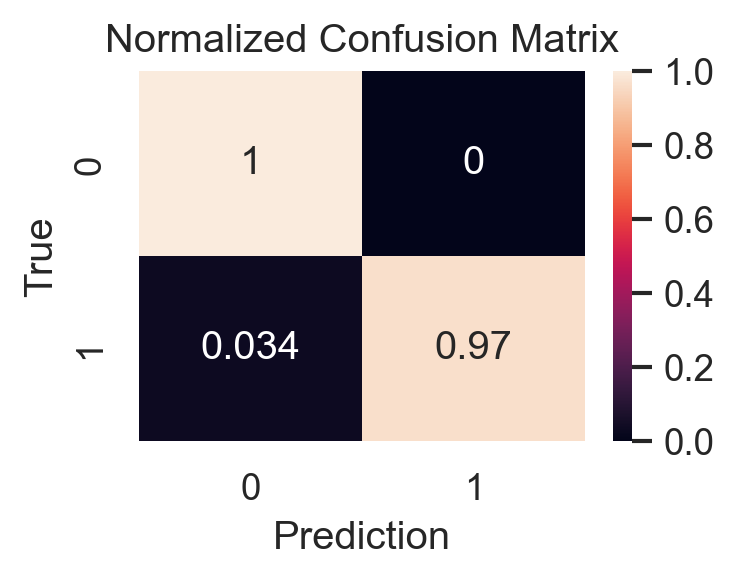

In [37]:
# svm model normalized confusion matrix
normalize_cmat(y_test,svc_test[1])

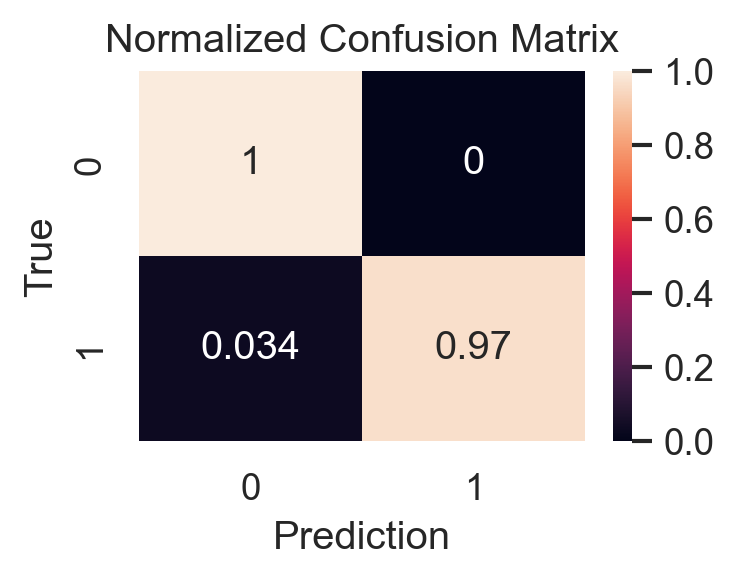

In [38]:
# Sgd model normalized confusion matrix
normalize_cmat(y_test,sgd_test[1])

# Answer
Based on the Test dataset F1 score values both ***SVC*** and ***SGD*** have performed equally, eventhough the F1 validation performance score of ***SGD*** is slightly lower than that of ***SVC***. This suggests that both the models are failing to capture the underlying idea of the features, thereby ***underfitting***, but both the models meet the clients requirement for having ***10% or less*** cases of ***false positives***, and ***5% or less*** cases of ***false negatives***.

## 3. Decision Boundaries (15% = 4.5 marks)

### 3.1 Rank features [1 mark]

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is (mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1))), where x1 and x2 are the datasets corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [39]:
# Your code here
# Seperate feature data based on label classification
positive_samples= cancer_df[cancer_df['label']==1].drop('label',axis=1)
negative_samples = cancer_df[cancer_df['label']==0].drop('label',axis=1)

t_sc_list=[]

print("T-score for top 4 feature")
print("")
# Calculating the T-score for each feature
for feature in positive_samples.columns:
    t_score=(np.mean(positive_samples[feature])-np.mean(negative_samples[feature]))/(0.5*(np.std(positive_samples[feature])+(np.std(negative_samples[feature]))))
    t_sc_list.append([feature,t_score])
top4=sorted(t_sc_list, key=lambda x: abs(x[1]),reverse=True)[:4]

# top 4 T-score
for value in top4:
    print(f'{value[0]} : {value[1]}')

T-score for top 4 feature

worst concave points : 2.4955288538105544
worst perimeter : 2.4814395467315733
worst radius : 2.418995524549576
mean concave points : 2.2369776759406097


### 3.2 Visualise decision boundaries [2.5 marks]

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the DecisionBoundaryDisplay function (as per workshop 6).

In [40]:
def decisionBoundary(feat_1,feat_2):

    # Extract features and target labels
    X = pd.DataFrame(np.concatenate((X_train[[feat_1,feat_2]],X_val[[feat_1,feat_2]]),axis=0))
    y = np.concatenate((y_train,y_val))

    sgd_pipe2.fit(X, y)

    # Create a meshgrid to plot the decision boundary
    h =0.02  # Step size in the mesh
    x_min, x_max = np.percentile(X[0],[5,95])
    y_min, y_max = np.percentile(X[1],[5,95])
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict on the meshgrid points
    Z = sgd_pipe2.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)

    # Plot the data points
    plt.scatter(X[0], X[1], c=y, edgecolors='k', s=100,cmap=plt.cm.coolwarm)

    # Set plot limits and labels
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(feat_1)
    plt.ylabel(feat_2)

    # Show the plot
    plt.title('Decision Boundary')
    plt.show()

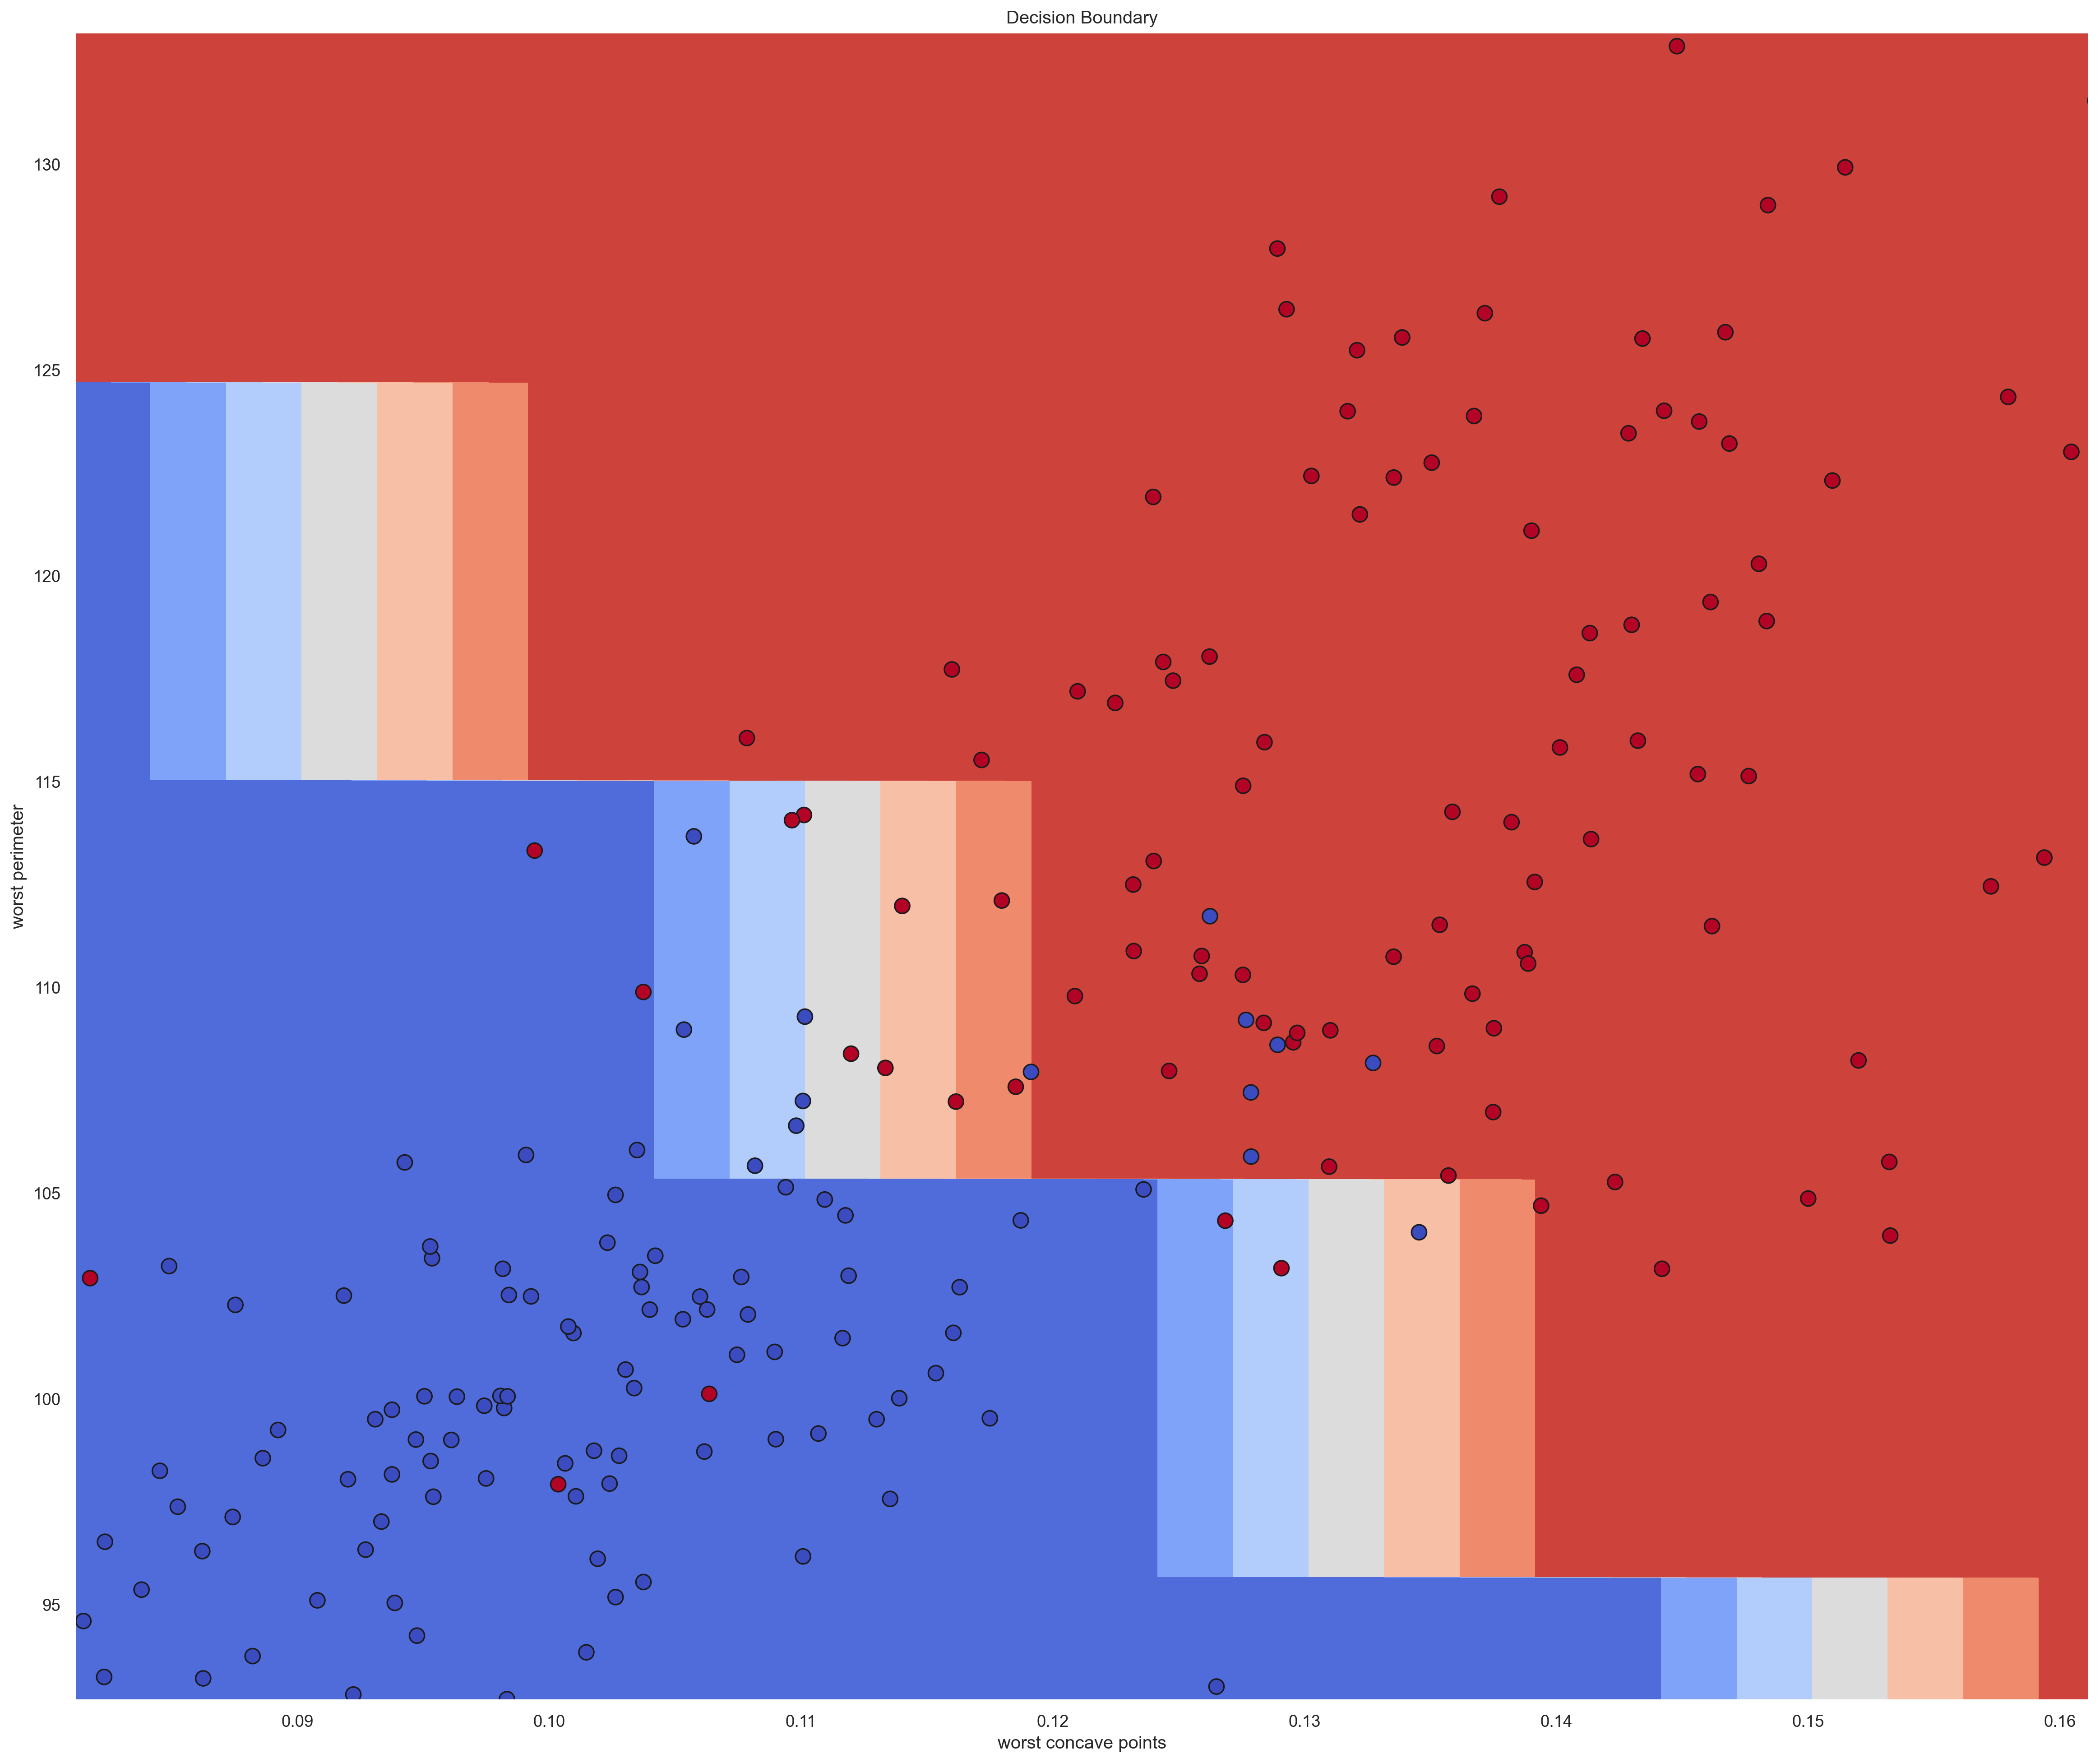

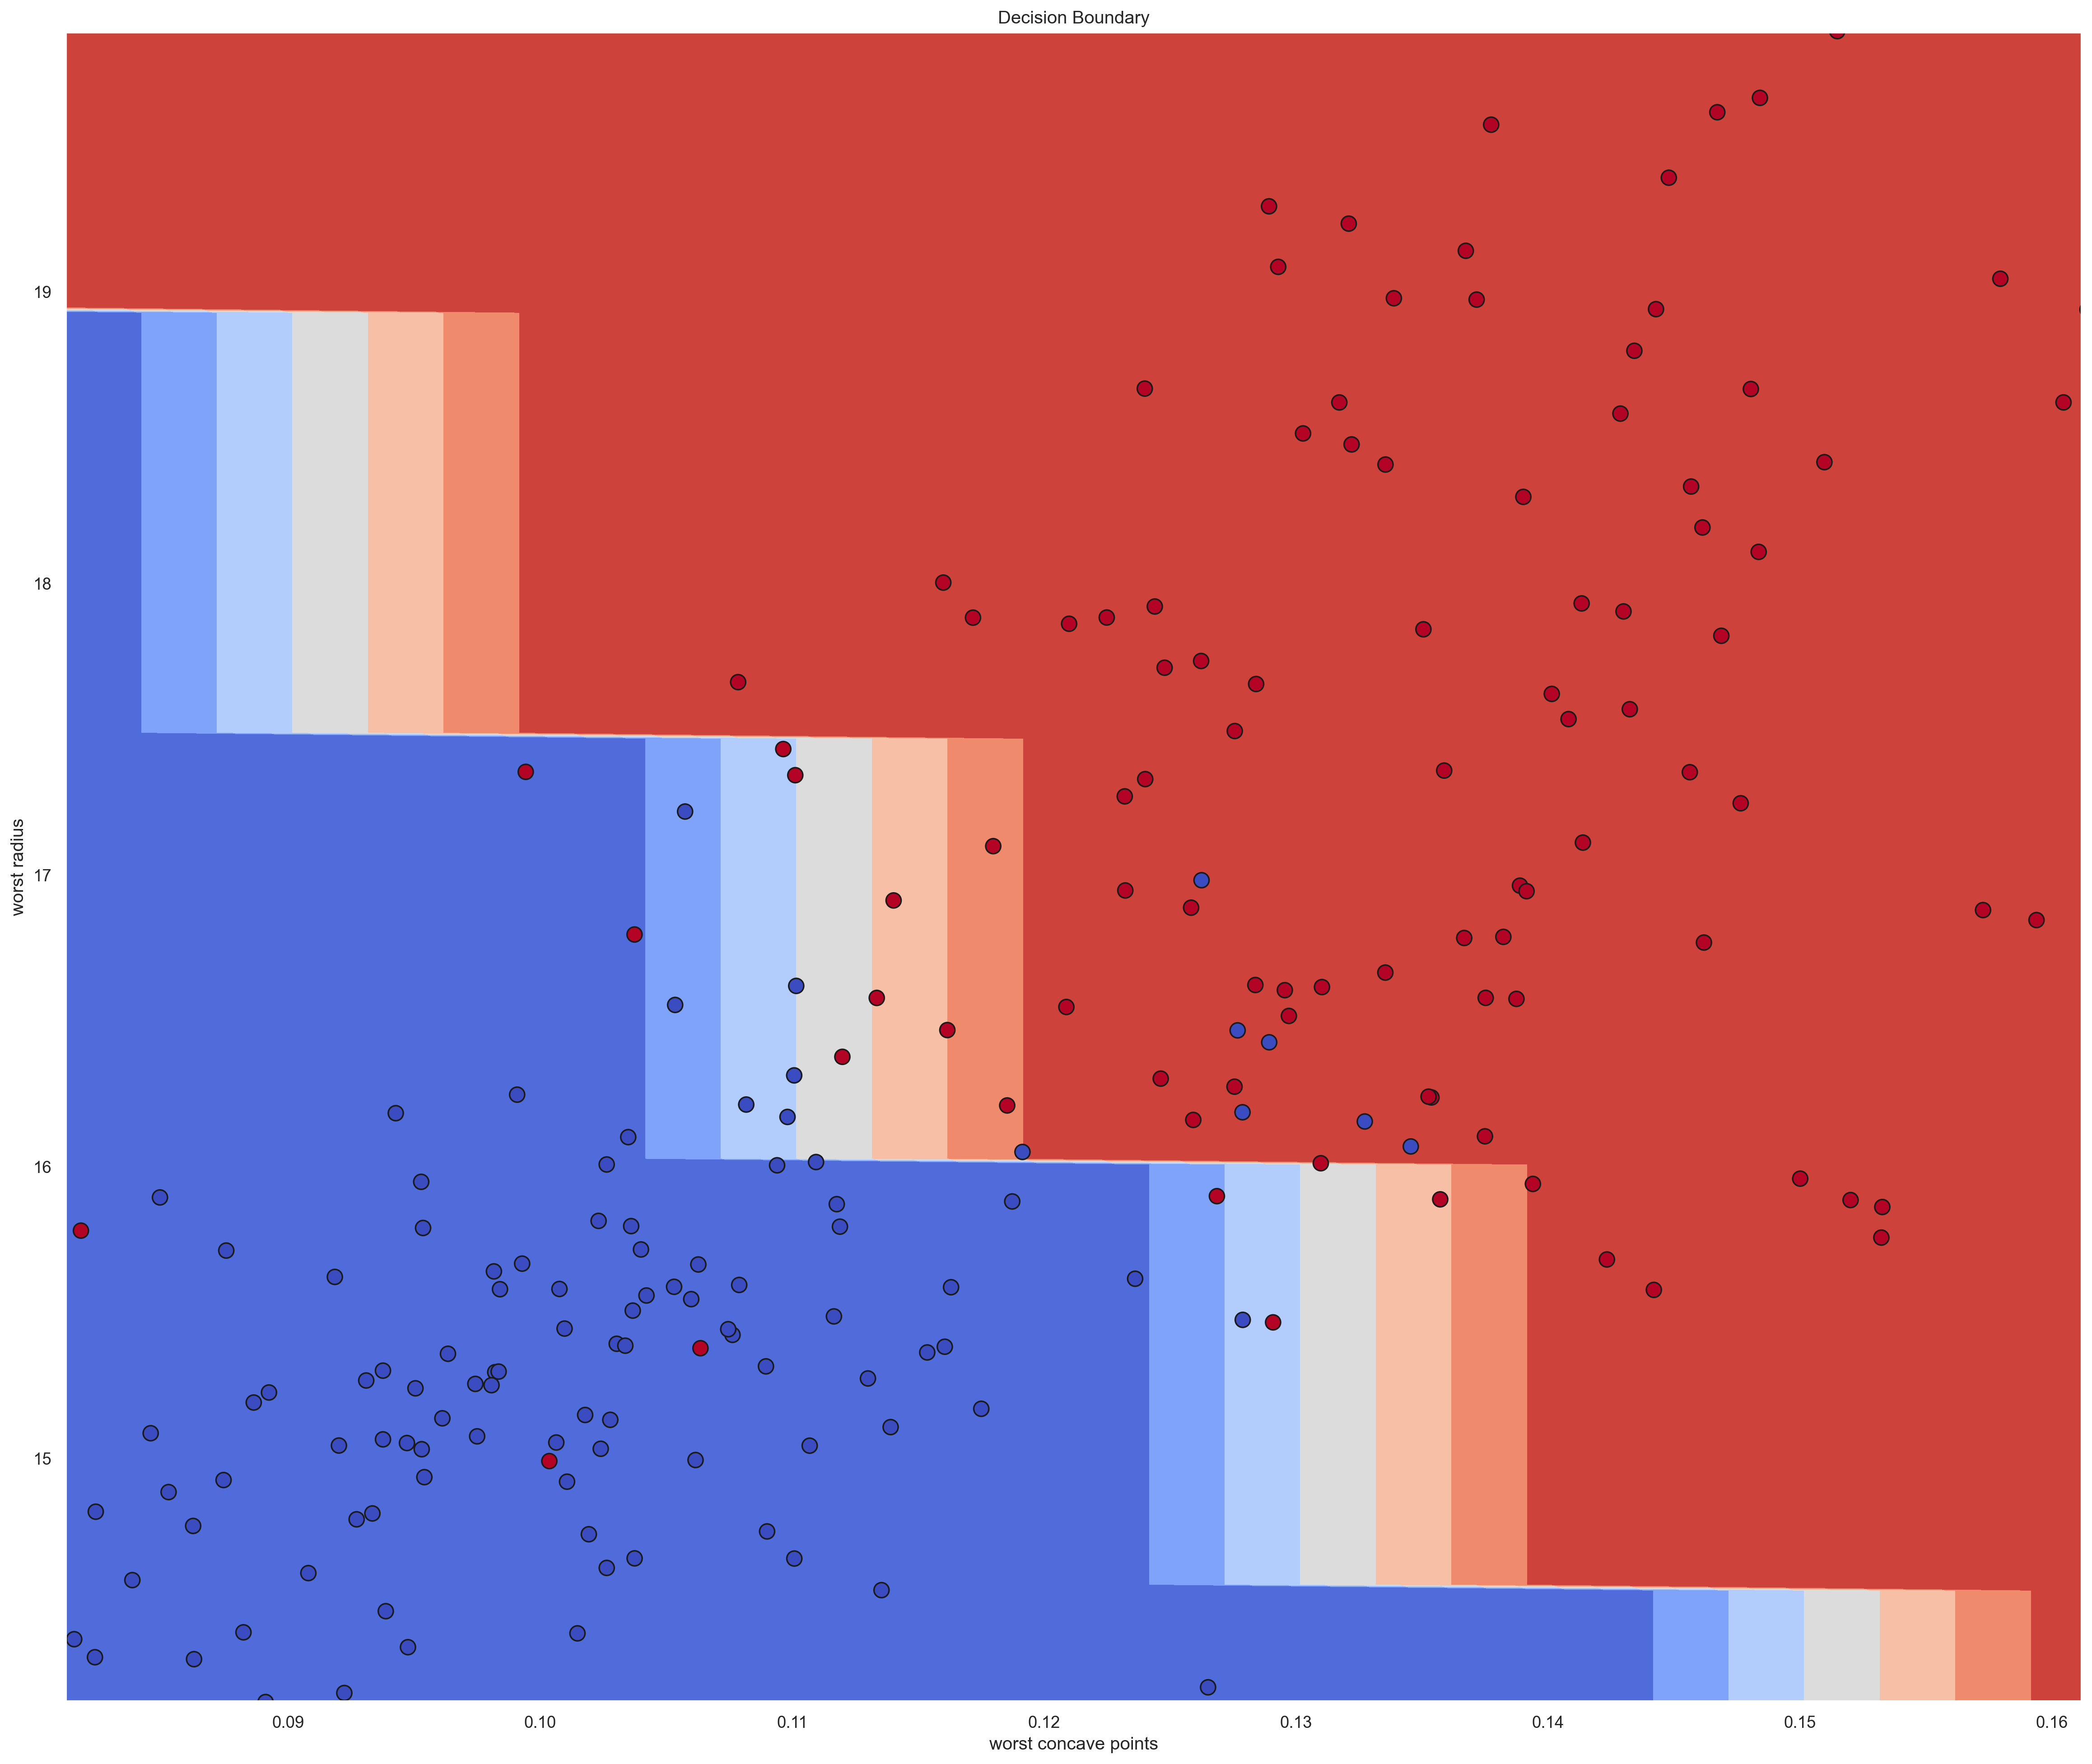

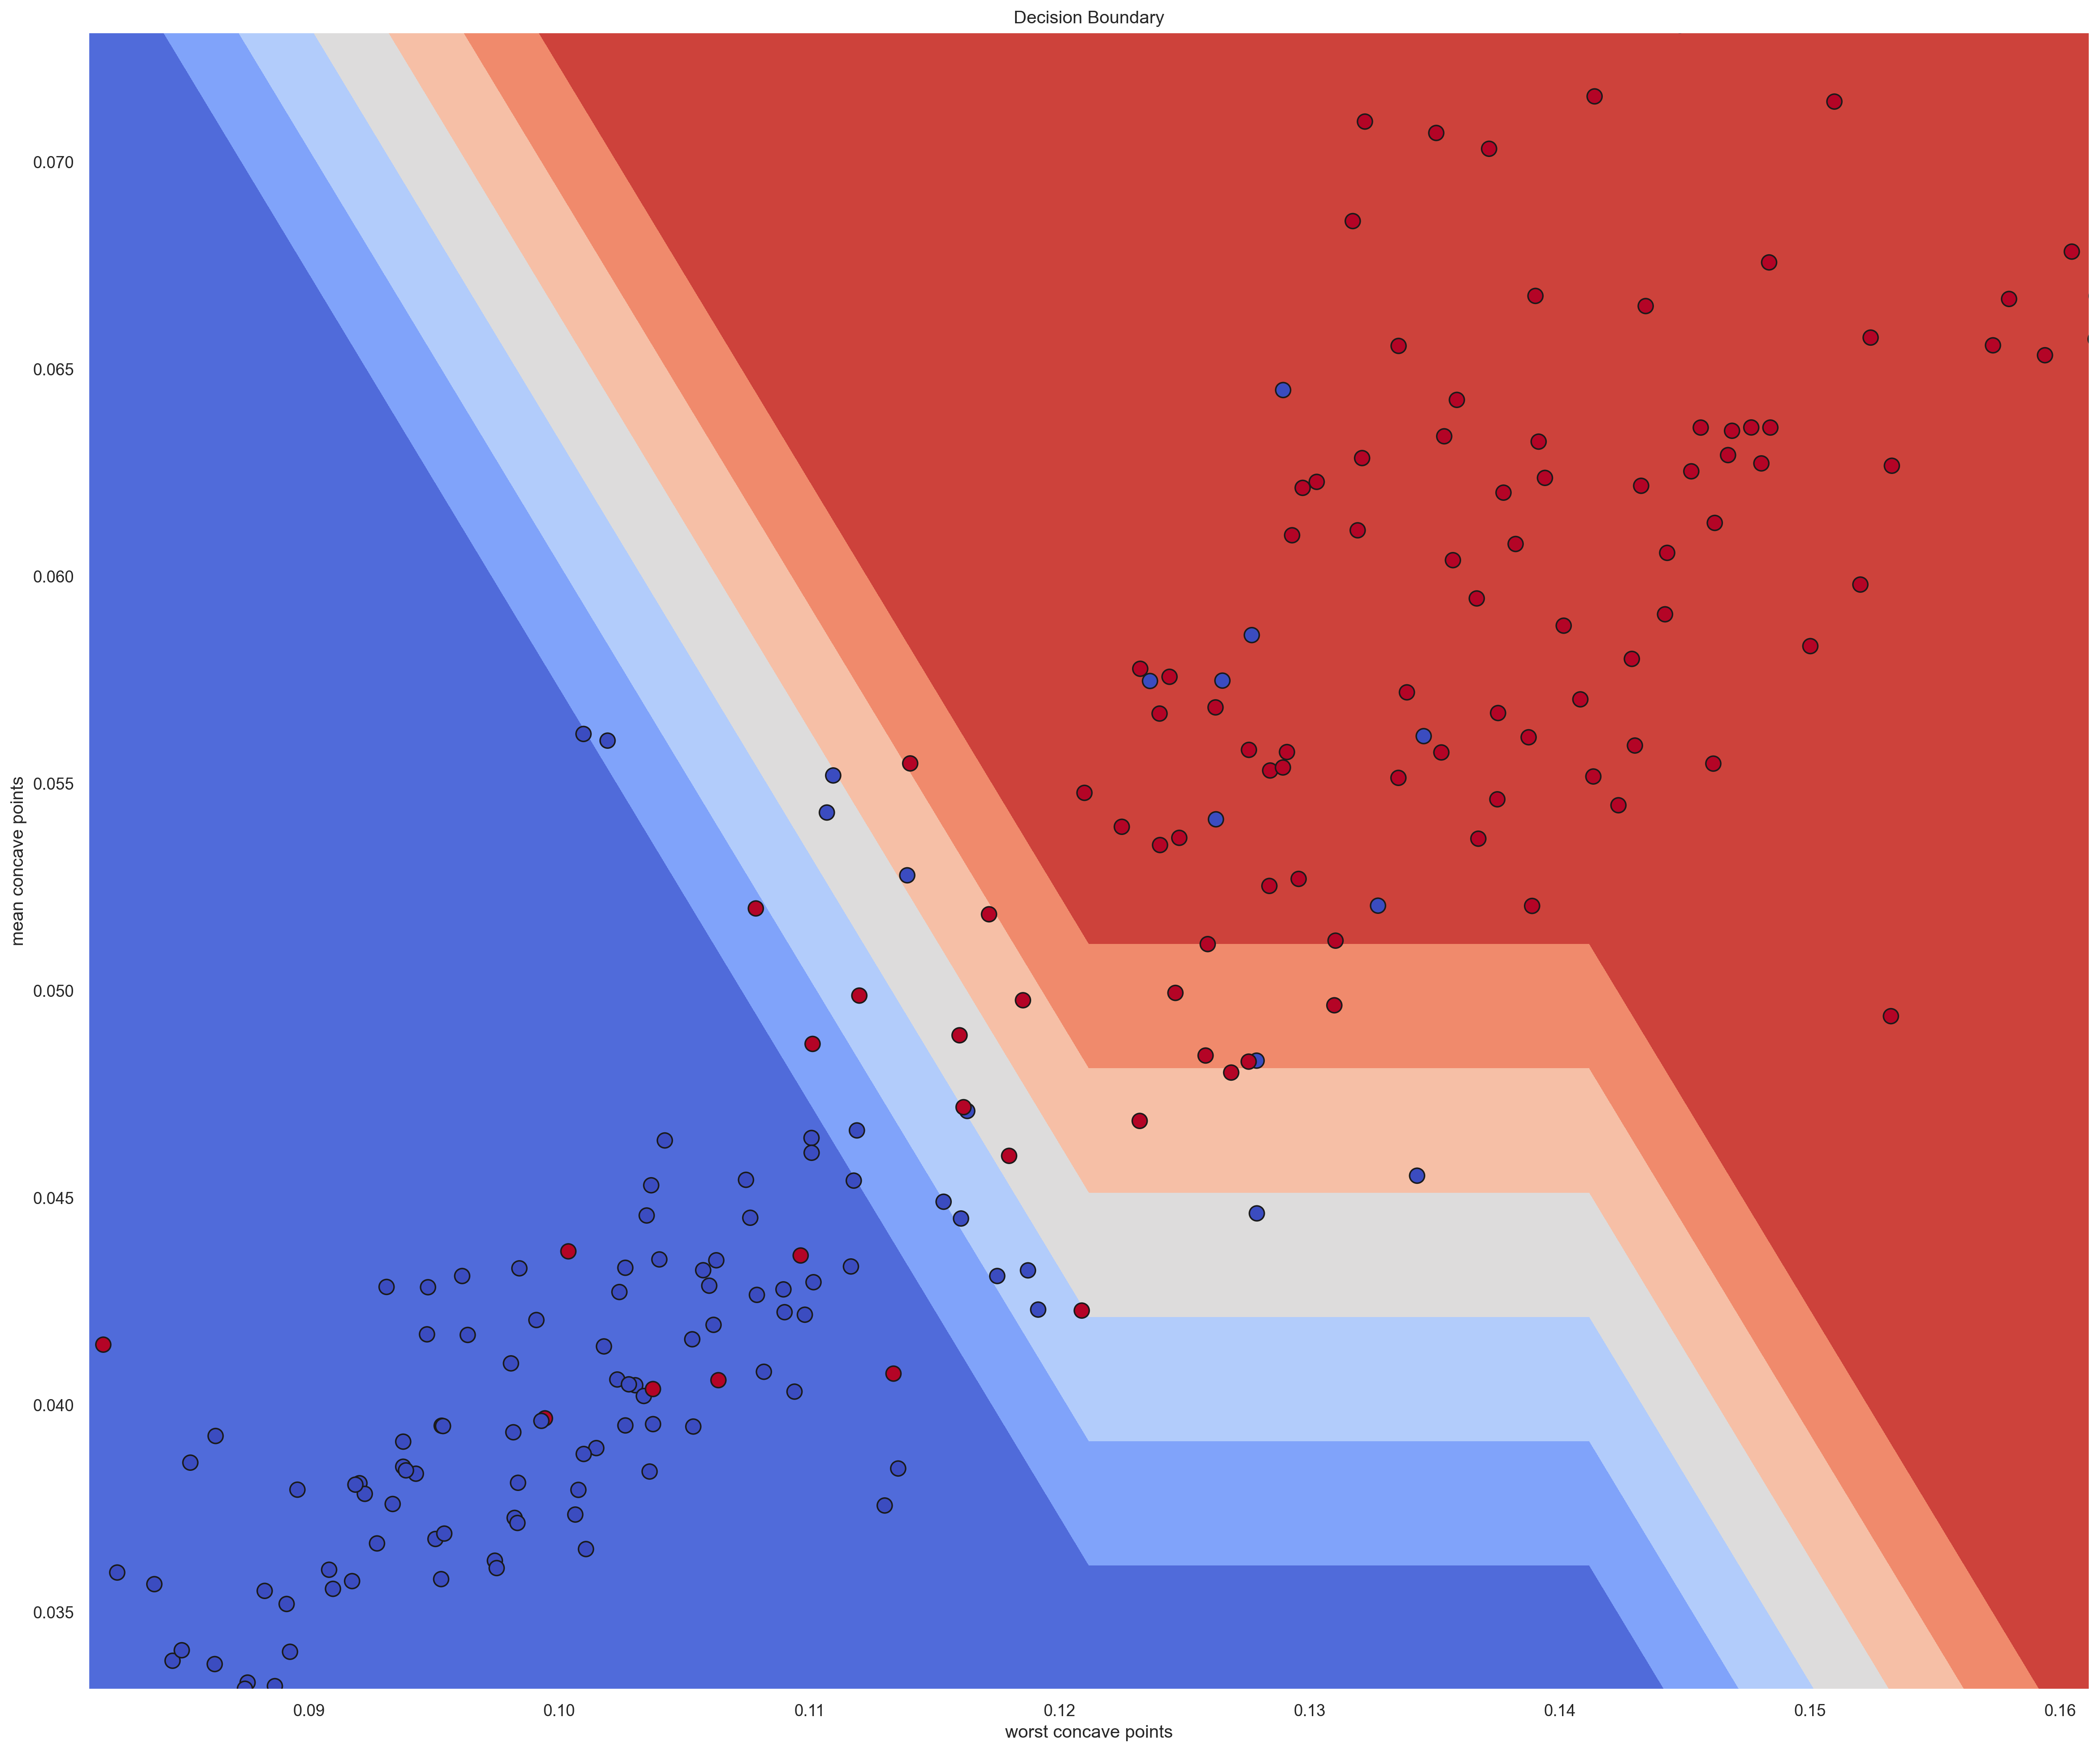

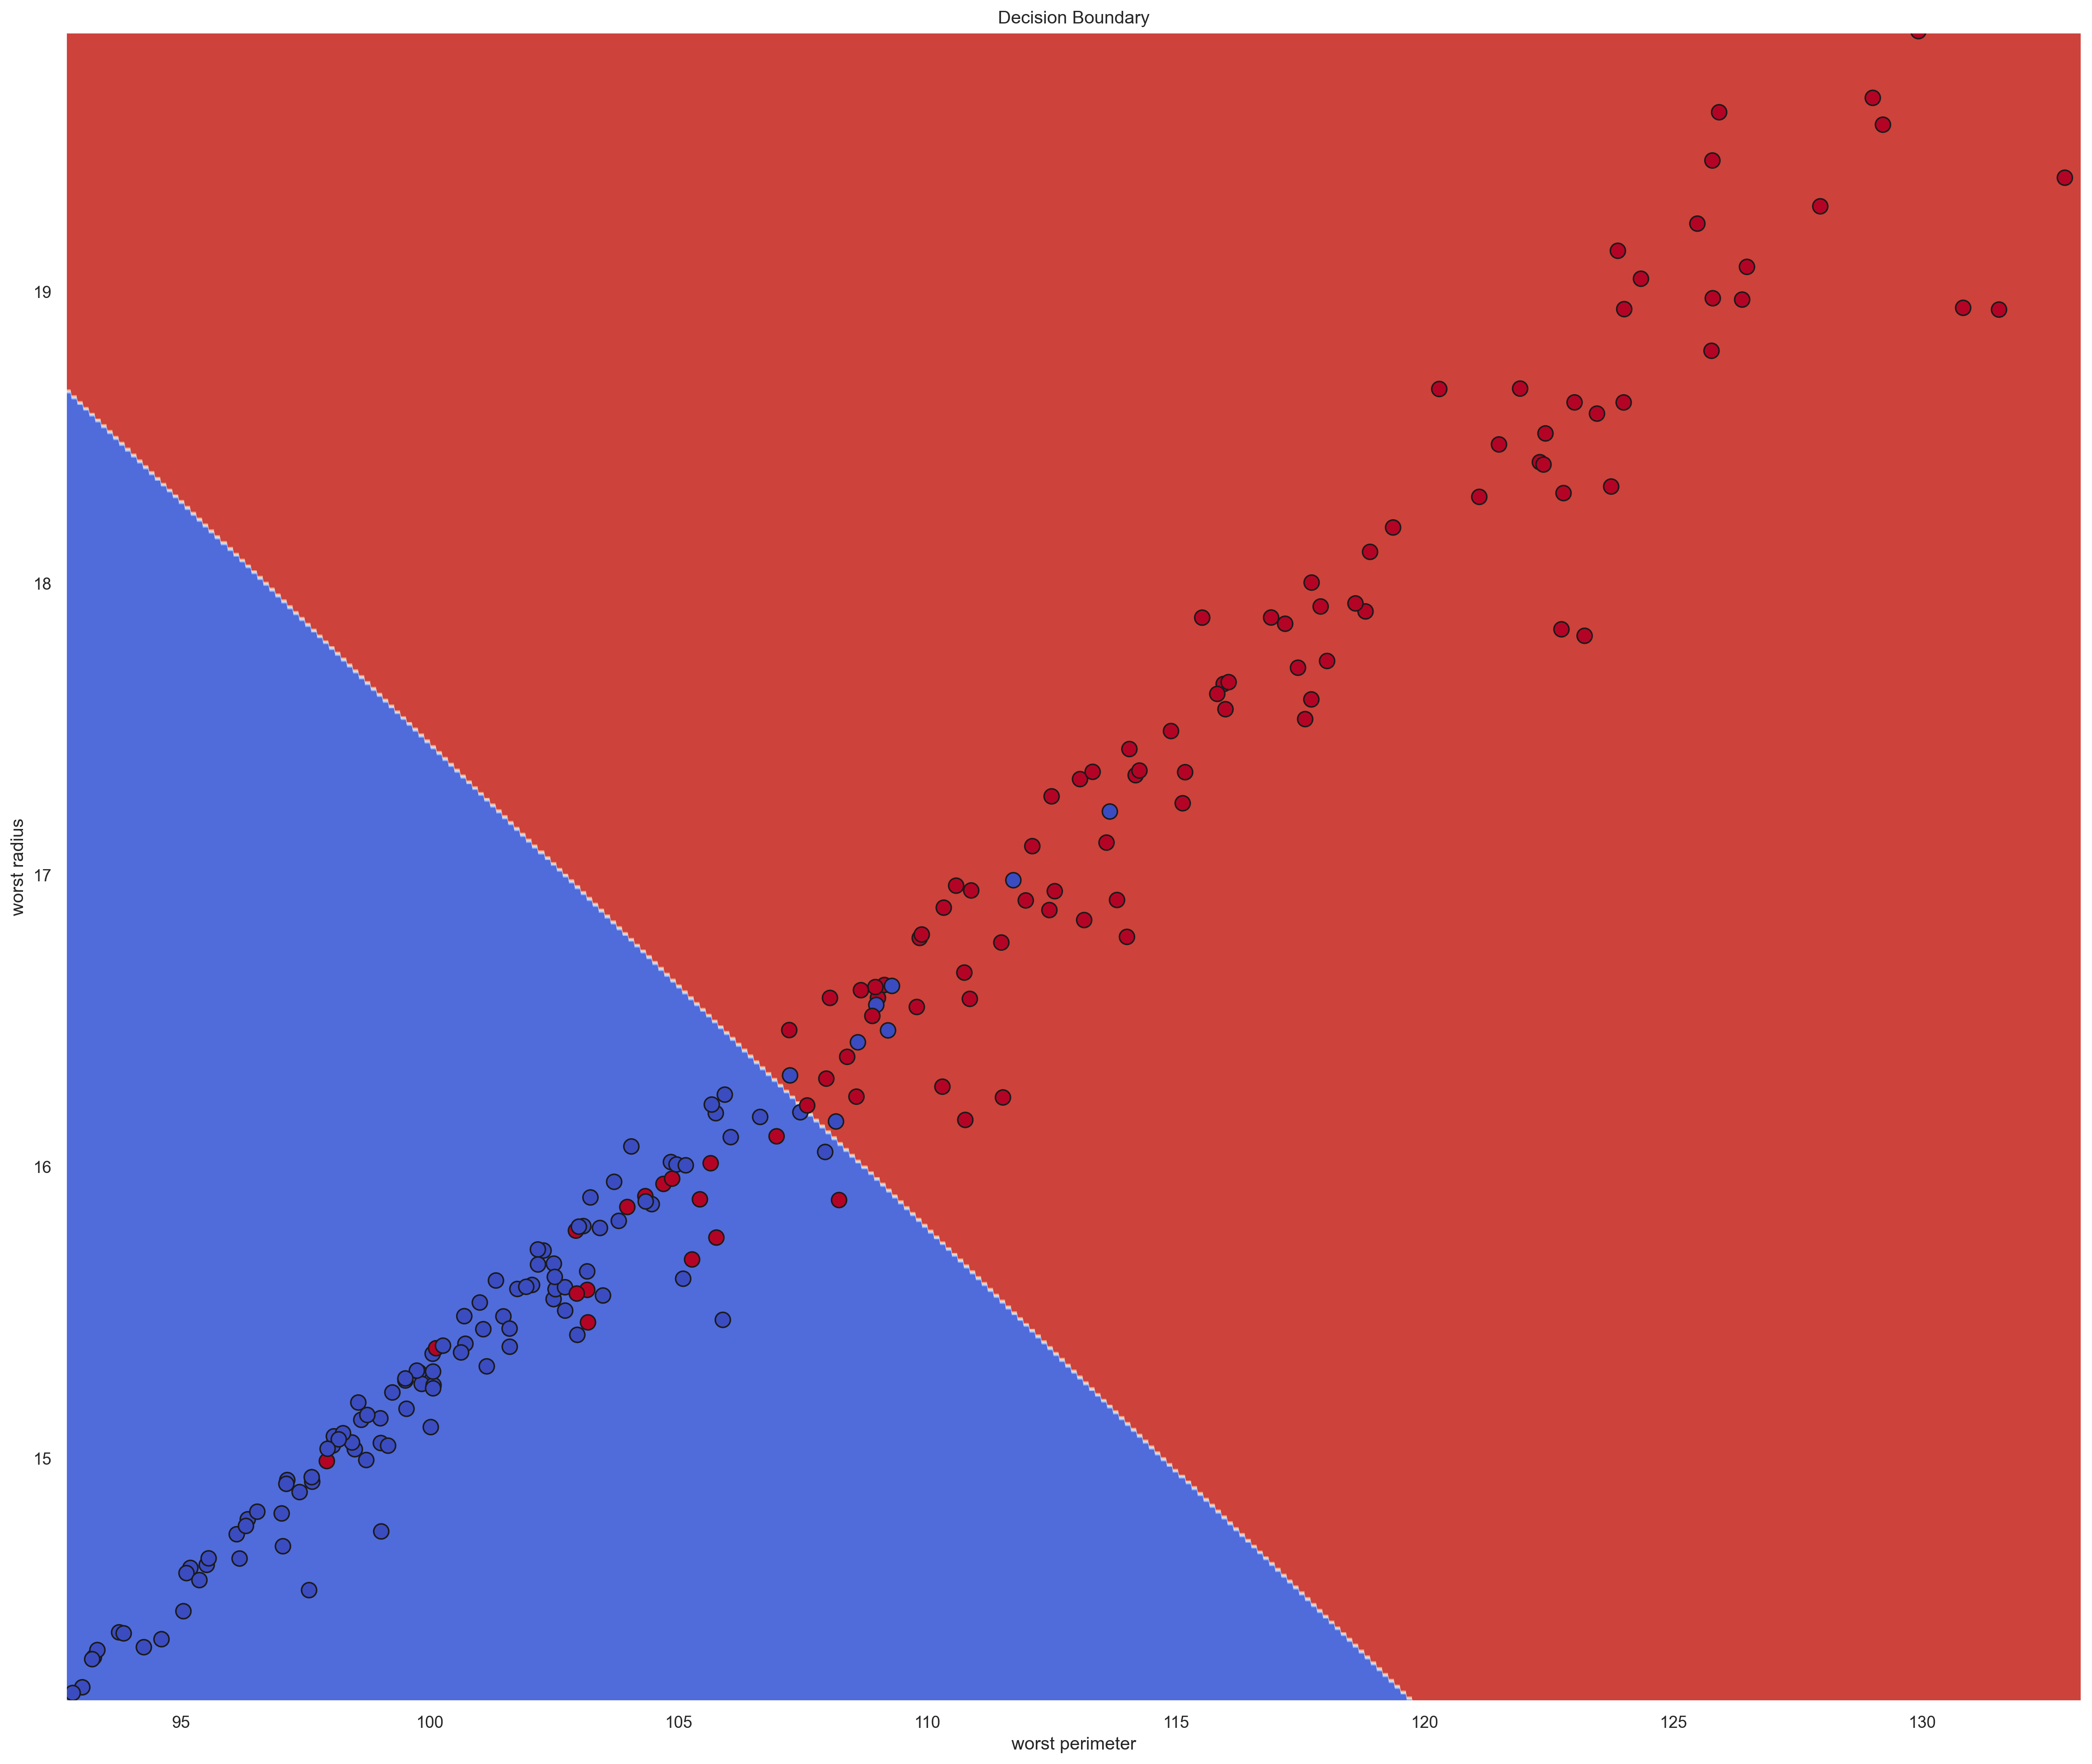

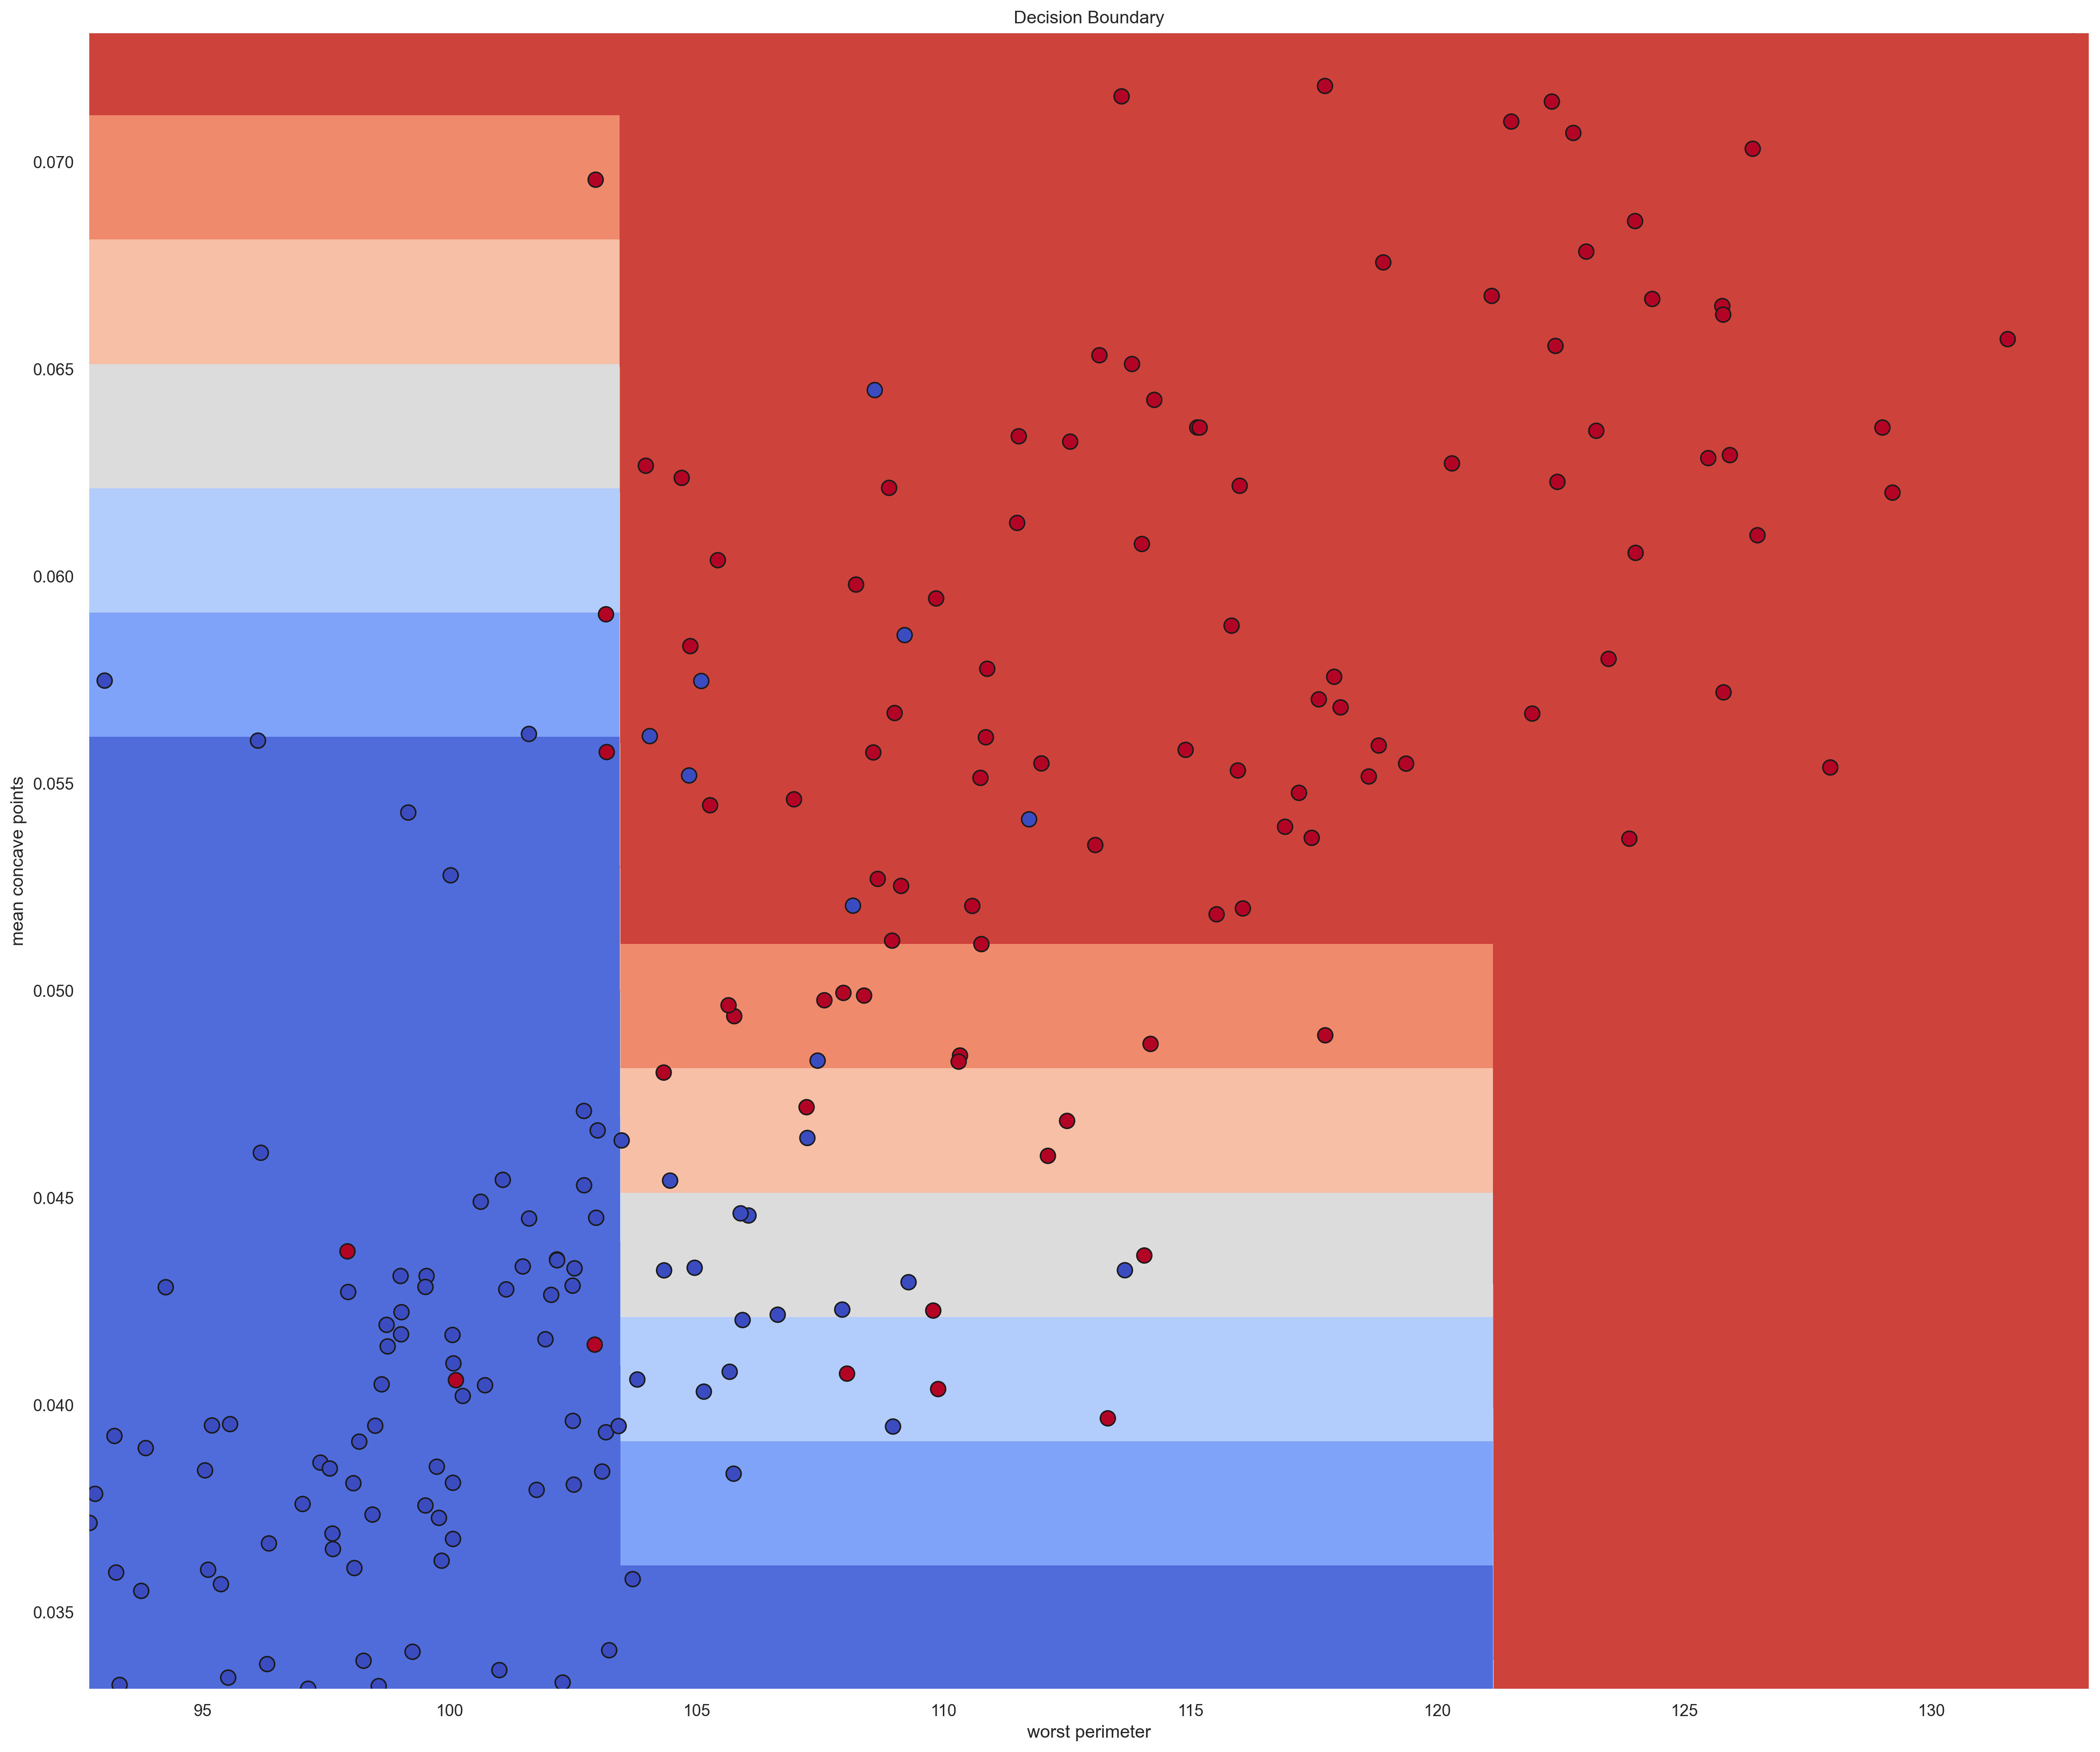

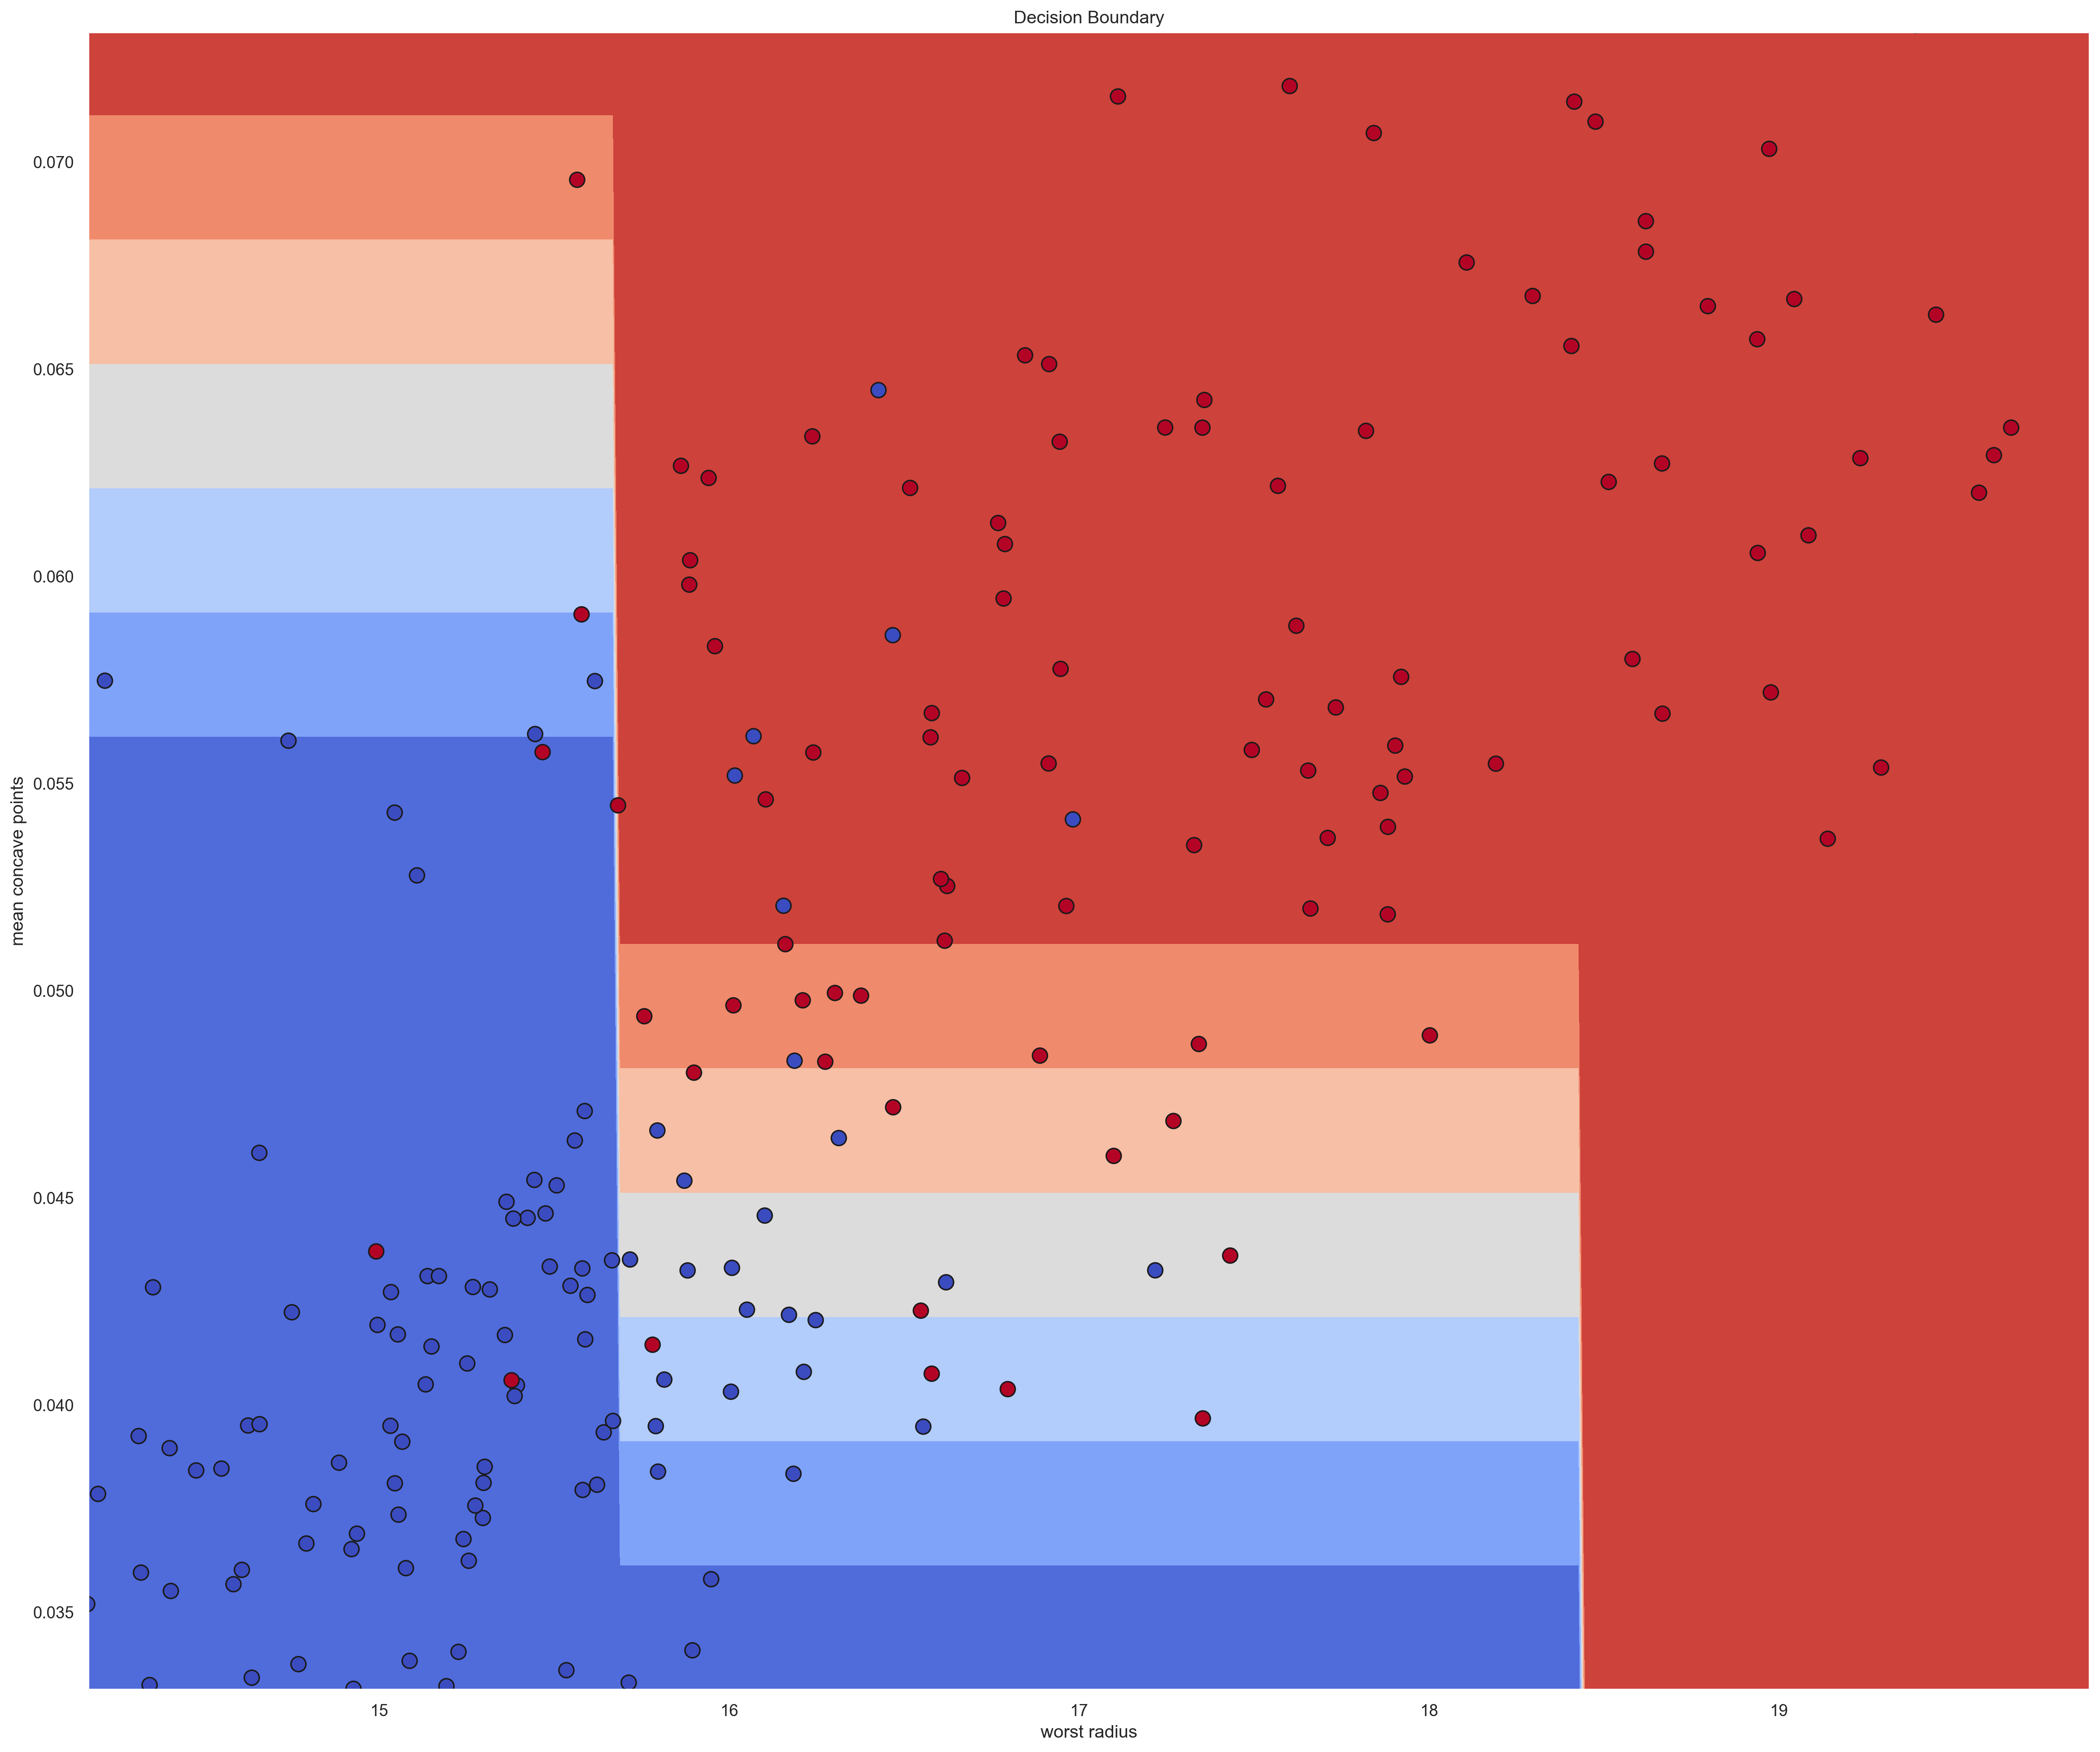

In [41]:
decisionBoundary('worst concave points', 'worst perimeter')
decisionBoundary('worst concave points', 'worst radius')
decisionBoundary('worst concave points', 'mean concave points')
decisionBoundary('worst perimeter', 'worst radius')
decisionBoundary('worst perimeter', 'mean concave points')
decisionBoundary('worst radius', 'mean concave points')


### 3.3 Interpretation [1 mark]

From the decision boundaries displayed above, **would you expect the method to extrapolate well or not**?  Give reasons for your answer.

# Answer

* **Data Spread**: Based on the above decision boundary distribution of data points, most of them appear to have a good spread among them when considering the location and space between the points and the decision boundary. Especially near the edges they seem to be distinct majority of the times. Suggesting that the model could be extrapolated to a certain extent.

* **Decision Boundary Shape**: Considering that the shape of the decision boundaries are linear but not well-defined, extrapolation might be challenging, and predictions might be less reliable.

* **Cross-Validation**: Based on the models performance score on the test data and the spread on decision bondary, it suggests that the model's generalizaion capabilities are quite well but could be improved. Therefore it is possible to extrapolate.

Finally, extrapolation is possible not to a vast extent as the model needs to be fine tuned further with more training data for better generalization.

## 4. Second Round (15% = 4.5 marks)

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask you to **give them a performance estimate for the same problem, but without using any of the "worst" features.**



### 4.1 New estimate [3.5 marks]

**Calculate an unbiased performance estimate** for this new problem, as requested by the client.

Validation F1 score : 0.8947368421052632

Test F1 score : 0.9259259259259259



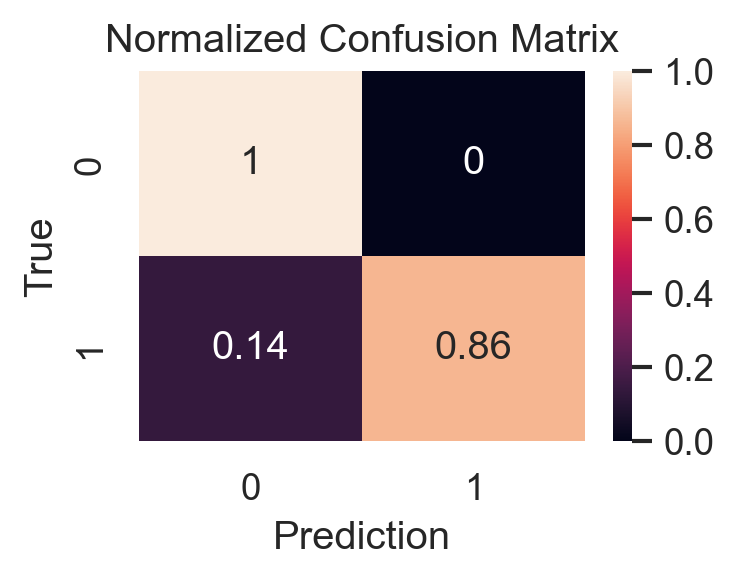

In [42]:
# Your code here
worst_features=[feature for feature in cancer_df.columns if 'worst' in feature]

X_new_train=X_train.drop(worst_features,axis=1)
X_new_val=X_val.drop(worst_features,axis=1)
X_new_test=X_test.drop(worst_features,axis=1)

validation_performance(X_new_train,X_new_val,svc_pipe2, y_train,y_val)
svc_test_new=test_performance(X_new_train,X_new_val,X_new_test,svc_pipe2, y_train,y_val,y_test)

normalize_cmat(y_test,svc_test_new[1])

### 4.2 Performance difference [1 mark]

Do you think the new classifier, that does not use the "worst" features, is:
 - **as good as the previous classifier** (that uses all the features)
 - **better than the previous classifier**
 - **worse than the previous classifier**
 
Give reasons for your answer.

# Answer

The validation and test F1 score seems to have dropped a little but not significantly. Eventhough it is **worse than the previous classifier**, it suggests that it is still able to predict quite alright even without the "worst" features, but performs better with those features.